# Radial Metallicity Gradients in NIHAO and GALAH


This script traces the face on position and iron abundance [Fe/H] of some of the youngest stars in a NIHAO simulation. It also overlays them on top of the gas density. To do so, it reads in the lite files of galaxy simulations from NIHAO and then performs.  

*How much does this picture deviate from a simple toy model of a linear Radius-[Fe/H] gradient and what can we learn about the real Milky Way?*


#### Github Repository

https://www.github.com/svenbuder/nihao_radial_metallicity_gradients

#### Author:
Sven Buder (ANU, sven.buder@anu.edu.au)

#### GALAH DR3:
Buder et al. (2021): https://ui.adsabs.harvard.edu/abs/2021MNRAS.506..150B

#### Open Cluster Memberships:
Cantat-Gaudin et al. (2020): https://ui.adsabs.harvard.edu/abs/2020A&A...633A..99C

#### Initial Data - NIHAO-UHD simulations:  
Buck (2020): https://ui.adsabs.harvard.edu/abs/2020MNRAS.491.5435B  
Buck et al. (2020b): https://ui.adsabs.harvard.edu/abs/2020MNRAS.491.3461B  
Buck et al. (2021): https://ui.adsabs.harvard.edu/abs/2021MNRAS.508.3365B  
Buck et al. (2023): https://ui.adsabs.harvard.edu/abs/2023MNRAS.523.1565B  
Buder, Mijnarends, and Buck (2024): https://ui.adsabs.harvard.edu/abs/2024arXiv240413835B  

#### Milky Way Spiral Arms and Young Stars:
Hawkins (2023): https://ui.adsabs.harvard.edu/abs/2023MNRAS.525.3318H  
Hackshaw et al. (2024): https://ui.adsabs.harvard.edu/abs/2024arXiv240518120H

In [1]:
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

# general packages
import numpy as np
from astropy.table import Table, join
import os
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy.stats import binned_statistic_2d
from scipy.odr import Model, RealData, ODR
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample

# astropy
import astropy.units as u
import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)

# matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm
from matplotlib.colors import LogNorm, Normalize
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.gridspec as gridspec
from matplotlib import rcParams
rcParams['axes.labelsize'] = 15
rcParams['legend.fontsize'] = 15
rcParams['figure.titlesize'] = 20

panels = [
    'a)','b)','c)',
    'd)','e)','f)',
    'g)','h)','i)',
    'j)','k)','l)',
    'm)','n)','o)',
    'q)','r)','s)',
    't)','u)','v)',
    'w)','x)','y)',
    'z)','aa)','ab)',
    'ac)','ad)','ae)'
]

# 2. Data: A NIHAO Milky Way analogue simulation

In [2]:
sim_stars = Table.read('data/NIHAO_g8.26e11_extensive_stars.fits')
sim_gas   = Table.read('data/NIHAO_g8.26e11_extensive_gas.fits')

sim_stars['R'] = np.sqrt(sim_stars['x']**2 + sim_stars['y']**2)
sim_stars['phi'] = np.arctan2(sim_stars['y'], sim_stars['x'])
sim_stars['phi_angle'] = sim_stars['phi'] * 180/np.pi + 180
sim_gas['R'] = np.sqrt(sim_gas['x']**2 + sim_gas['y']**2)

In [3]:
# Major selection:
nihao_R_max = 20 # kpc
nihao_z_max = 10 # kpc
nihao_age_max = 1 # Gyr

In [4]:
young_within_r_max = (
    (sim_stars['age'] < nihao_age_max) &
    (sim_stars['R'] < nihao_R_max)# & 
#     (abs(sim_stars['z']) < nihao_z_max)
)

abs_z_young_within_r_max_99perc = np.round(np.percentile(np.abs(sim_stars['z'][young_within_r_max]),q=99),1)
np.savetxt('tex_text/abs_z_young_within_r_max_99perc.tex',[r'$\vert z \vert = '+str(abs_z_young_within_r_max_99perc)+'\,\mathrm{kpc}$%'],fmt='%s')

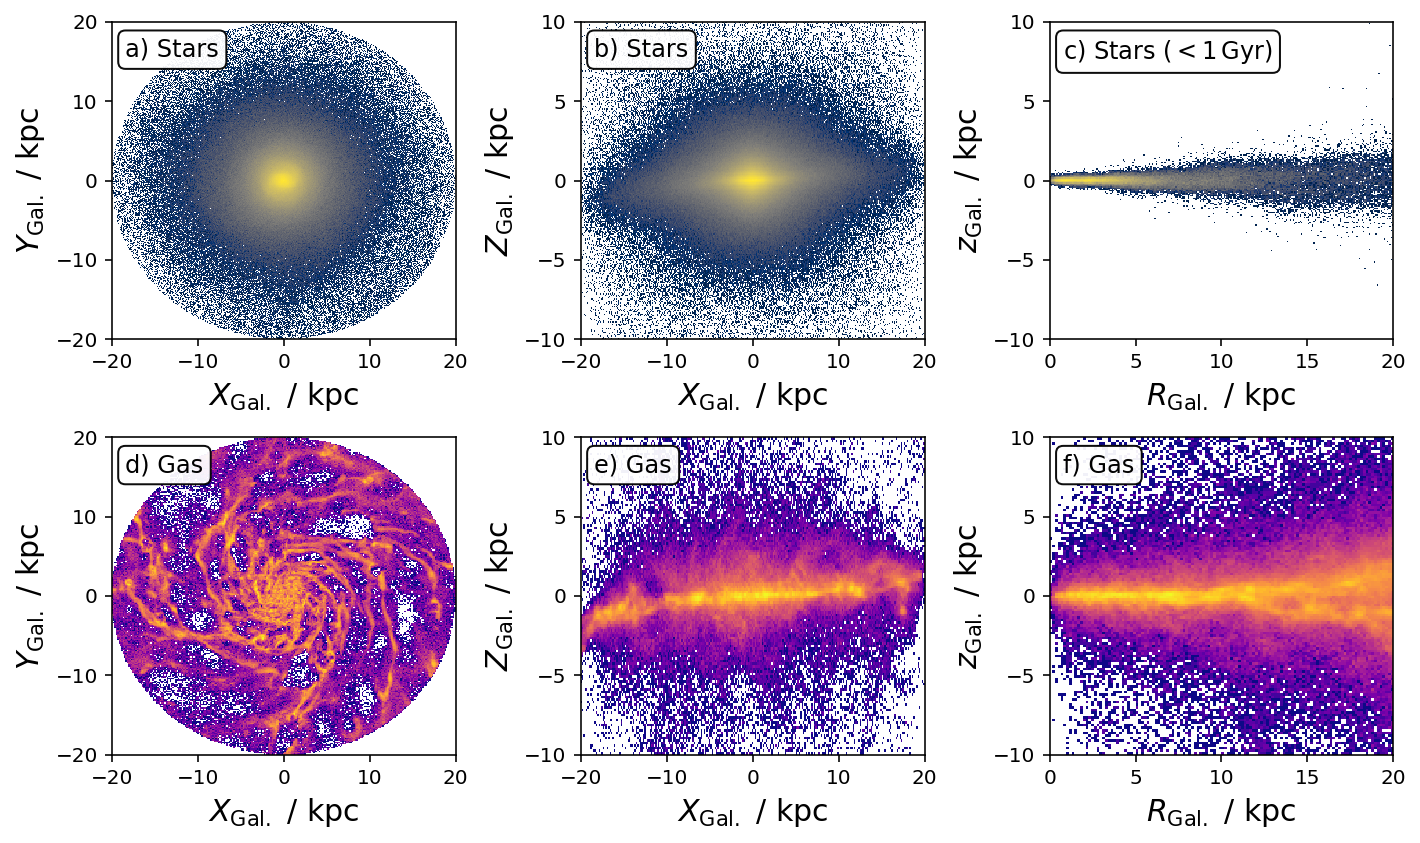

In [5]:
f, gs = plt.subplots(2,3,figsize=(10,6))

axes = gs.flatten()

# Stars

ax = axes[0]
ax.text(0.04,0.95,panels[0]+' Stars',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.set_xlabel(r'$X_\mathrm{Gal.}~/~\mathrm{kpc}$')
ax.set_ylabel(r'$Y_\mathrm{Gal.}~/~\mathrm{kpc}$')

within_r_max = (
    (sim_stars['R'] < nihao_R_max) & 
    (abs(sim_stars['z']) < nihao_z_max)
)

young_within_r_max = (
    (sim_stars['age'] < nihao_age_max) &
    (sim_stars['R'] < nihao_R_max) & 
    (abs(sim_stars['z']) < nihao_z_max)
)

ax.hist2d(
    sim_stars['x'][within_r_max],
    sim_stars['y'][within_r_max],
    bins = (np.linspace(-nihao_R_max,nihao_R_max,500),np.linspace(-nihao_R_max,nihao_R_max,500)),
    cmin = 1, cmap = 'cividis', norm=LogNorm()
)

ax = axes[1]
ax.text(0.04,0.95,panels[1]+' Stars',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.set_xlabel(r'$X_\mathrm{Gal.}~/~\mathrm{kpc}$')
ax.set_ylabel(r'$Z_\mathrm{Gal.}~/~\mathrm{kpc}$')

ax.hist2d(
    sim_stars['x'][within_r_max],
    sim_stars['z'][within_r_max],
    bins = (np.linspace(-nihao_R_max,nihao_R_max,500),np.linspace(-nihao_z_max,nihao_z_max,250)),
    cmin = 1, cmap = 'cividis', norm=LogNorm()
)

ax = axes[2]
ax.text(0.04,0.95,panels[2]+r' Stars ($< '+str(nihao_age_max)+'\,\mathrm{Gyr}$)',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.set_xlabel(r'$R_\mathrm{Gal.}~/~\mathrm{kpc}$')
ax.set_ylabel(r'$z_\mathrm{Gal.}~/~\mathrm{kpc}$')

ax.hist2d(
    sim_stars['R'][young_within_r_max],
    sim_stars['z'][young_within_r_max],
    bins = (np.linspace(0,nihao_R_max,250),np.linspace(-nihao_z_max,nihao_z_max,250)),
    cmin = 1, cmap = 'cividis', norm=LogNorm()
)

ax = axes[3]
ax.text(0.04,0.95,panels[3]+' Gas',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.set_xlabel(r'$X_\mathrm{Gal.}~/~\mathrm{kpc}$')
ax.set_ylabel(r'$Y_\mathrm{Gal.}~/~\mathrm{kpc}$')

within_r_max = (
    (sim_gas['R'] < nihao_R_max) & 
    (abs(sim_gas['z']) < nihao_z_max)
)

ax.hist2d(
    sim_gas['x'][within_r_max],
    sim_gas['y'][within_r_max],
    bins = (np.linspace(-nihao_R_max,nihao_R_max,250),np.linspace(-nihao_R_max,nihao_R_max,250)),
    cmin = 1, cmap = 'plasma', norm=LogNorm()
)

ax = axes[4]
ax.text(0.04,0.95,panels[4]+' Gas',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.set_xlabel(r'$X_\mathrm{Gal.}~/~\mathrm{kpc}$')
ax.set_ylabel(r'$Z_\mathrm{Gal.}~/~\mathrm{kpc}$')

ax.hist2d(
    sim_gas['x'][within_r_max],
    sim_gas['z'][within_r_max],
    bins = (np.linspace(-nihao_R_max,nihao_R_max,250),np.linspace(-nihao_z_max,nihao_z_max,125)),
    cmin = 1, cmap = 'plasma', norm=LogNorm()
)

ax = axes[5]
ax.text(0.04,0.95,panels[5]+' Gas',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.set_xlabel(r'$R_\mathrm{Gal.}~/~\mathrm{kpc}$')
ax.set_ylabel(r'$z_\mathrm{Gal.}~/~\mathrm{kpc}$')

ax.hist2d(
    sim_gas['R'][within_r_max],
    sim_gas['z'][within_r_max],
    bins = (np.linspace(0,nihao_R_max,125),np.linspace(-nihao_z_max,nihao_z_max,125)),
    cmin = 1, cmap = 'plasma', norm=LogNorm()
)

plt.tight_layout(w_pad=0.5, h_pad=0.5)
plt.savefig('figures/stars_and_gas_overview.png',dpi=300,bbox_inches='tight')
plt.show()
plt.close()

# 3 Radius Metallicity Gradients

## 3.1 Linearity of the gradient

### Linear Fit

In [6]:
different_results = dict()

# Let's fit a linear model to all data points
in_range = (
        (sim_stars['R'] < nihao_R_max) &
        (sim_stars['age'] < nihao_age_max)
)

# Fit a linear regression model
R    = sim_stars['R'][in_range].reshape(-1, 1)  # Reshape for sklearn
Fe_H = sim_stars['Fe_H'][in_range]

model_global = LinearRegression()
model_global.fit(R, Fe_H)

different_results['sklearn_LinearRegression'] = [model_global.intercept_, model_global.coef_[0]]

# Calculate predicted fe_h and residuals
sim_stars['Fe_H_linear_model'] = model_global.predict(sim_stars['R'].reshape(-1, 1))
sim_stars['Fe_H_residuals'] = sim_stars['Fe_H'] - sim_stars['Fe_H_linear_model']

### Quadratic Fit

In [7]:
# Example data
R    = sim_stars['R'][in_range]
Fe_H = sim_stars['Fe_H'][in_range]

# Add a constant term (for the intercept) and an R^2 term
R2 = R**2
R_matrix = sm.add_constant(np.column_stack((R, R2)))  # This stacks R and R^2 and adds a constant term

# Fit the model
model_global_quadratic = sm.OLS(Fe_H, R_matrix)
model_global_quadratic_results = model_global_quadratic.fit()

digits = 5
floating = '{:.'+str(digits)+'f}'

intercept, linear_term, quadratic_term = [floating.format(x) for x in np.round(model_global_quadratic_results.params,6)]
intercept_sigma, linear_term_sigma, quadratic_term_sigma = [floating.format(x) for x in np.round(np.sqrt(np.diag(model_global_quadratic_results.cov_params())),6)]

def flattening_radial_metallicity_gradient(R):
    intercept, linear_term, quadratic_term = model_global_quadratic_results.params
    return(intercept + linear_term * R + quadratic_term * R**2)

text = r'G(R_\mathrm{Gal},R_\mathrm{Gal}^2) = $\mathrm{[Fe/H]} = '+intercept+' \pm '+intercept_sigma+' ('+linear_term+' \pm '+linear_term_sigma+') \cdot R_\mathrm{Gal.} ('+quadratic_term+' \pm '+quadratic_term_sigma+') \cdot R_\mathrm{Gal.}^2$%'
print(text)

np.savetxt(
    'tex_text/quadratic_model_global.tex',
    [text],
    fmt = '%s'
)

G(R_\mathrm{Gal},R_\mathrm{Gal}^2) = $\mathrm{[Fe/H]} = 0.48273 \pm 0.00046 (-0.04970 \pm 0.00015) \cdot R_\mathrm{Gal.} (0.00050 \pm 0.00001) \cdot R_\mathrm{Gal.}^2$%


In [8]:
# Data
x = sim_stars['R'][in_range]
y = sim_stars['Fe_H'][in_range]

# Dictionary to store results
results = {}

# 1. Ordinary Least Squares (OLS) using Statsmodels
x_sm = sm.add_constant(x)  # adds a constant term to the predictor
model_sm = sm.OLS(y, x_sm)
results_sm = model_sm.fit()
results[r'\textsc{statsmodels.api.ODR}'] = [results_sm.params[0], results_sm.bse[0], results_sm.params[1], results_sm.bse[1]]

# 2. Total Least Squares (TLS) or Orthogonal Regression using SciPy ODR
def linear_func(p, x):
    return p[0] * x + p[1]

data = RealData(x, y)
model_odr = Model(linear_func)
odr = ODR(data, model_odr, beta0=[0., 1.])
out_odr = odr.run()
results[r'\textsc{scipy.odr}'] = [out_odr.beta[1], out_odr.sd_beta[1], out_odr.beta[0], out_odr.sd_beta[0]]

# 3. Polynomial Fitting using NumPy polyfit
coefficients, covariance = np.polyfit(x, y, 1, cov=True)
if covariance is None:
    std_error_poly = [0, 0]  # In case the covariance matrix couldn't be computed
else:
    std_error_poly = np.sqrt(np.diag(covariance))  # Standard errors

results[r'\textsc{np.polyfit}'] = [coefficients[1], std_error_poly[1], coefficients[0], std_error_poly[0]]

# 4. Machine Learning Approaches with Scikit-Learn (bootstrap for uncertainty)
model_sklearn = LinearRegression()
intercepts = []
slopes = []

for _ in range(10):  # Number of bootstrap samples
    x_boot, y_boot = resample(x.reshape(-1, 1), y)
    model_sklearn.fit(x_boot, y_boot)
    intercepts.append(model_sklearn.intercept_)
    slopes.append(model_sklearn.coef_[0])

intercept_mean = np.mean(intercepts)
intercept_std = np.std(intercepts)
slope_mean = np.mean(slopes)
slope_std = np.std(slopes)
results['\\textsc{LinearRegression}'] = [intercept_mean, intercept_std, slope_mean, slope_std]

# Start building the LaTeX table string
latex_table = """
\\begin{table}
\\caption{Global linear gradient fit results with different methods. \\textsc{LinearRegression} is part of the \\textsc{sklearn} package.}
\\label{tab:global_fit_results_per_method}
\\begin{tabularx}{\\columnwidth}{lCC}
\\hline
Method & Intercept ($a_0 \\pm \\sigma_{a_0}$) & Slope ($a_1 \\pm \\sigma_{a_1}$) \\\\
\\hline
"""

# Add each method's results to the LaTeX table
for method, values in results.items():
    latex_table += f"{method} & ${values[0]:.5f} \\pm {values[1]:.5f}$ & ${values[2]:.5f} \\pm {values[3]:.5f}$ \\\\\n"

latex_table += "\\hline\n"
# Close the LaTeX table
latex_table += "\\end{tabularx}\n"
latex_table += "\\end{table}"

np.savetxt('tables/global_fit_results_per_method.tex',[latex_table],fmt='%s')
# Print LaTeX table
print(latex_table)


\begin{table}
\caption{Global linear gradient fit results with different methods. \textsc{LinearRegression} is part of the \textsc{sklearn} package.}
\label{tab:global_fit_results_per_method}
\begin{tabularx}{\columnwidth}{lCC}
\hline
Method & Intercept ($a_0 \pm \sigma_{a_0}$) & Slope ($a_1 \pm \sigma_{a_1}$) \\
\hline
\textsc{statsmodels.api.ODR} & $0.46229 \pm 0.00033$ & $-0.04114 \pm 0.00004$ \\
\textsc{scipy.odr} & $0.46232 \pm 0.00033$ & $-0.04114 \pm 0.00004$ \\
\textsc{np.polyfit} & $0.46229 \pm 0.00033$ & $-0.04114 \pm 0.00004$ \\
\textsc{LinearRegression} & $0.46214 \pm 0.00026$ & $-0.04111 \pm 0.00008$ \\
\hline
\end{tabularx}
\end{table}


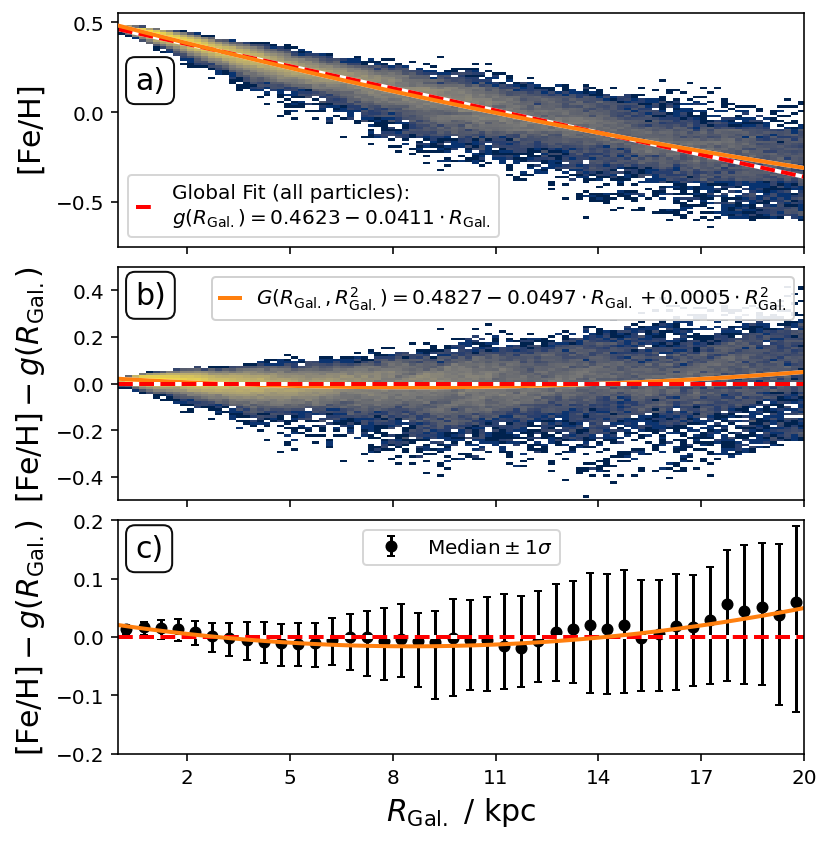

In [92]:
f, axes = plt.subplots(3,1,figsize=(6,6),sharex=True)

axes = axes.flatten()

ax = axes[0]
ax.text(0.025,0.65,panels[0],fontsize=15,transform=ax.transAxes,va='bottom',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
# ax.set_xlabel(r'$R_\mathrm{Gal.}~/~\mathrm{kpc}$')
ax.set_ylabel(r'$\mathrm{[Fe/H]}$')

ax.hist2d(
    sim_stars['R'][in_range],
    sim_stars['Fe_H'][in_range],
    cmin = 1, cmap = 'cividis',
    norm = LogNorm(),
    bins = (np.linspace(0,20,100),np.linspace(-0.75,0.55,100)),
    zorder = 1
)

R_line = np.linspace(0,nihao_R_max,100)
Fe_H_line = model_global.predict(R_line.reshape(-1, 1))

ax.plot(
    R_line,
    flattening_radial_metallicity_gradient(R_line),
    c = 'w',lw=2,
    zorder = 2
)
ax.plot(
    R_line,
    flattening_radial_metallicity_gradient(R_line),
    c = 'C1',lw=2,
    zorder = 3
)

ax.plot(
    R_line,
    Fe_H_line,
    c = 'w',lw=2,
    zorder = 2
)
s2 = ax.plot(
    R_line,
    Fe_H_line,
    c = 'r',lw=2,ls='dashed',
    zorder = 2, label = 'Global Fit (all particles):\n'+r'$g(R_\mathrm{Gal.}) = '+"{:.4f}".format(model_global.intercept_)+' '+"{:.4f}".format(model_global.coef_[0])+'\cdot R_\mathrm{Gal.}$'
)

ax.legend(loc='lower left', fontsize=10, handlelength=1)
ax.set_xlim(0,nihao_R_max)
# ax.set_xticks([2,5,8,11,14,17,20])

ax = axes[1]
ax.text(0.025,0.94,panels[1],fontsize=15,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
# ax.set_xlabel(r'$R_\mathrm{Gal.}~/~\mathrm{kpc}$')
ax.set_ylabel(r'$\mathrm{[Fe/H]} - g(R_\mathrm{Gal.})$')

ax.hist2d(
    sim_stars['R'][in_range],
    sim_stars['Fe_H_residuals'][in_range],
    cmin = 1, cmap = 'cividis',
    norm = LogNorm(),
    bins = (np.linspace(0,20,100),np.linspace(-0.5,0.5,100)),
    zorder = 1
)

ax.plot(
    R_line,
    flattening_radial_metallicity_gradient(R_line) - Fe_H_line.T,
    c = 'w',lw=2,
    zorder = 2
)
ax.plot(
    R_line,
    flattening_radial_metallicity_gradient(R_line) - Fe_H_line.T,
    c = 'C1',lw=2,
    zorder = 2, label = r'$G(R_\mathrm{Gal.},R_\mathrm{Gal.}^2) = '+"{:.4f}".format(model_global_quadratic_results.params[0])+' '+"{:.4f}".format(model_global_quadratic_results.params[1])+'\cdot R_\mathrm{Gal.} + '+"{:.4f}".format(model_global_quadratic_results.params[2])+'\cdot R_\mathrm{Gal.}^2$'
)

ax.plot(
    R_line,
    np.zeros(len(R_line)),
    c = 'w',lw=2,
    zorder = 2
)
s2 = ax.plot(
    R_line,
    np.zeros(len(R_line)),
    c = 'r',lw=2,ls='dashed',
    zorder = 2
)

ax.legend(loc='upper right', fontsize=10, handlelength=1, framealpha=0.9)


# ax.set_xlim(0,nihao_R_max)
# ax.set_xticks([2,5,8,11,14,17,20])

ax = axes[2]
ax.text(0.025,0.94,panels[2],fontsize=15,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.set_xlabel(r'$R_\mathrm{Gal.}~/~\mathrm{kpc}$')
ax.set_ylabel(r'$\mathrm{[Fe/H]} - g(R_\mathrm{Gal.})$')

R_bins = np.linspace(0,nihao_R_max,41)

Fe_H_spread = []

for R_index, (R_bin_min, R_bin_max) in enumerate(zip(R_bins[:-1],R_bins[1:])):

    in_R = (
        (sim_stars['R'] > R_bin_min) &
        (sim_stars['R'] <= R_bin_max) &
        (sim_stars['age'] < 1.0)
    )

    perc = np.percentile(sim_stars['Fe_H_residuals'][in_R],q=[16,50,84])

    if R_index == 0:
        label = r'$\mathrm{Median}\pm 1 \sigma$'
    else:
        label = '_nolegend_'

    s = ax.errorbar(
        0.5*(R_bin_min+R_bin_max),
        perc[1],
        yerr = [[perc[1]-perc[0]],[perc[2]-perc[1]]],
        c = 'k',ms=5,fmt='o',label = label,
        capsize=2, zorder = 1
    )
    
    if R_bin_min in [0.0,8.0,19.0]:
        Fe_H_spread = np.round(0.5*(perc[2]-perc[0]),2)
        np.savetxt('tex_text/fe_h_spread_at_R_'+str(int(R_bin_min))+'kpc.tex',[r'$\sigma \mathrm{[Fe/H]} = '+str(Fe_H_spread)+'\,\mathrm{dex}$%'],fmt='%s')
        
    if R_index == 0:
        legend_labels = []
        legend_labels.append(s)

ax.plot(
    R_line,
    np.zeros(len(R_line)),
    c = 'w',lw=2,
    zorder = 2
)
s2 = ax.plot(
    R_line,
    np.zeros(len(R_line)),
    c = 'r',lw=2,ls='dashed',
    zorder = 2
)

s2 = ax.plot(
    R_line,
    flattening_radial_metallicity_gradient(R_line) - Fe_H_line.T,
    c = 'C1',lw=2,
    zorder = 2
)

ax.set_ylim(-0.2,0.2)

ax.set_xlim(0,nihao_R_max)
ax.set_xticks([2,5,8,11,14,17,20])

ax.legend(loc = 'upper center', fontsize=10)

plt.tight_layout(h_pad=0)

plt.savefig('figures/global_r_feh_fit.png',dpi=300,bbox_inches='tight')
plt.show()
plt.close()

### How do fitting ranges influence the slope estimate?

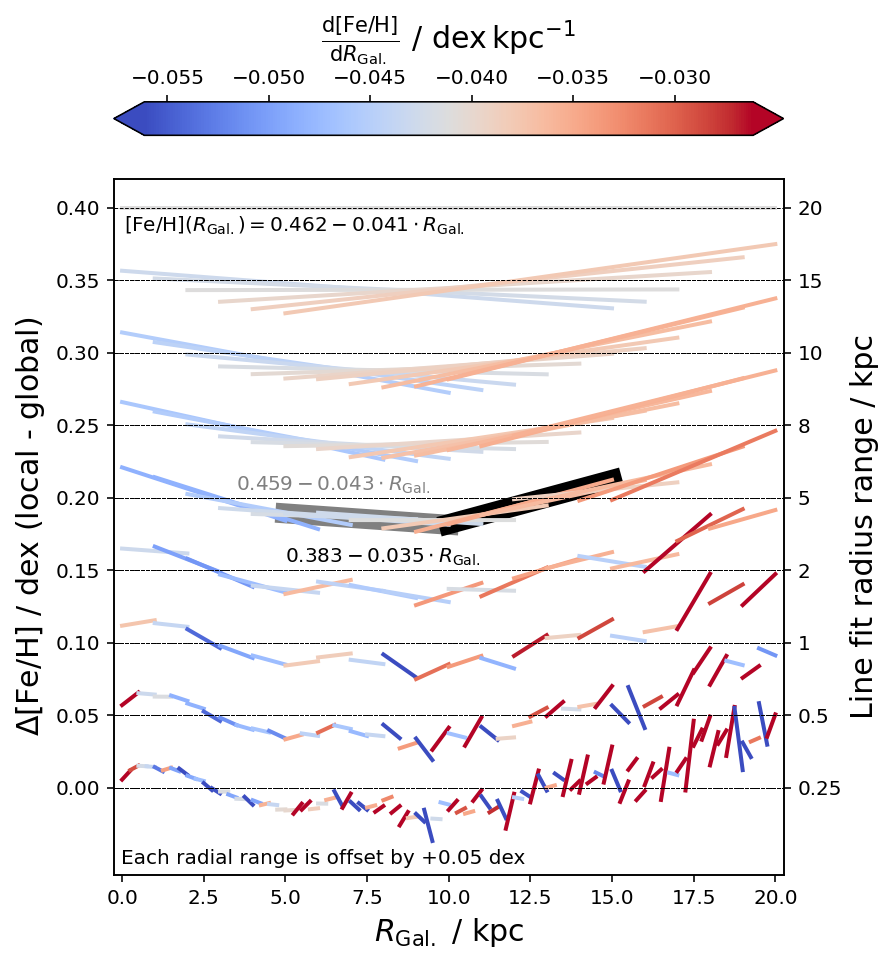

In [105]:
f, ax = plt.subplots(figsize=(6,8))

radial_ranges = [0.25, 0.5, 1, 2, 5, 8, 10, 15,20]
radial_range_ticks = np.arange(len(radial_ranges)) * 0.05

norm = Normalize(vmin=model_global.coef_[0] - 0.015, vmax=model_global.coef_[0] + 0.015)
cmap = plt.get_cmap('coolwarm')

for radial_index, radial_range in enumerate(radial_ranges):

    increment = 1
    if radial_range < 1:
        increment = radial_range
    radial_mins = np.arange(0,nihao_R_max - radial_range+increment, increment)
    radial_maxs = np.arange(radial_range,nihao_R_max+increment, increment)
    
    
    for radial_range_index, (radial_min, radial_max) in enumerate(zip(radial_mins, radial_maxs)):


        in_radial_range = (
            (sim_stars['R'] >= radial_min) &
            (sim_stars['R'] <= radial_max) &
            (sim_stars['age'] <= nihao_age_max)
        )

        R    = sim_stars['R'][in_radial_range].reshape(-1, 1)  # Reshape for sklearn
        Fe_H = sim_stars['Fe_H'][in_radial_range]

        radial_model = LinearRegression()
        radial_model.fit(R, Fe_H)
        
        R_plot = np.linspace(radial_min, radial_max)
        Fe_H_plot = radial_model.predict(R_plot.reshape(-1,1)) - model_global.predict(R_plot.reshape(-1,1))
        
        if (radial_range == 5) & (radial_min == 5):
            ax.plot(
                R_plot,
                Fe_H_plot + radial_range_ticks[radial_index],
                color='grey', lw=10,
                zorder = 1
            )
            ax.text(3.5, radial_range_ticks[radial_index]+0.005,r'$'+"{:.3f}".format(radial_model.intercept_)+"{:.3f}".format(radial_model.coef_[0])+r'\cdot R_\mathrm{Gal.}$', color = 'grey')
            np.savetxt('tex_text/linear_gradient_5_10_kpc.tex',[r'$\mathrm{[Fe/H]}(R_\mathrm{Gal.}) = '+"{:.3f}".format(radial_model.intercept_)+"{:.3f}".format(radial_model.coef_[0])+r'\cdot R_\mathrm{Gal.}$%'],fmt='%s')
        
        if (radial_range == 5) & (radial_min == 10):
            ax.plot(
                R_plot,
                Fe_H_plot + radial_range_ticks[radial_index],
                color='k', lw=10,
                zorder = 1
            )
            ax.text(5, radial_range_ticks[radial_index]-0.045,r'$'+"{:.3f}".format(radial_model.intercept_)+"{:.3f}".format(radial_model.coef_[0])+r'\cdot R_\mathrm{Gal.}$', color = 'k')
            np.savetxt('tex_text/linear_gradient_10_15_kpc.tex',[r'$\mathrm{[Fe/H]}(R_\mathrm{Gal.}) = '+"{:.3f}".format(radial_model.intercept_)+"{:.3f}".format(radial_model.coef_[0])+r'\cdot R_\mathrm{Gal.}$%'],fmt='%s')
        
        ax.plot(
            R_plot,
            Fe_H_plot + radial_range_ticks[radial_index],
            color=cmap(norm(radial_model.coef_[0])),
            zorder = 2, lw=2
        )
        
        if radial_range == 20:
            ax.text(0.05, radial_range_ticks[radial_index]-0.02,r'$\mathrm{[Fe/H]}(R_\mathrm{Gal.}) = '+"{:.3f}".format(model_global.intercept_)+"{:.3f}".format(model_global.coef_[0])+r'\cdot R_\mathrm{Gal.}$', va='bottom')
            np.savetxt('tex_text/linear_gradient_global.tex',[r'$\mathrm{[Fe/H]}(R_\mathrm{Gal.}) = '+"{:.3f}".format(model_global.intercept_)+"{:.3f}".format(model_global.coef_[0])+r'\cdot R_\mathrm{Gal.}$%'],fmt='%s')

        ax.axhline(radial_range_ticks[radial_index], lw=0.5, c='k', ls='dashed')

ax.set_ylim(-0.06,0.42)
ax.set_yticks(radial_range_ticks)
ax.set_ylabel('$\Delta \mathrm{[Fe/H]}$ / dex (local - global)')
ax.text(0.01,0.01,'Each radial range is offset by +0.05 dex',transform=ax.transAxes,ha='left',va='bottom',fontsize=10)
ax.set_xlabel(r'$R_\mathrm{Gal.}~/~\mathrm{kpc}$')

ax2 = ax.twinx()
ax2.set_yticks(radial_range_ticks)
ax2.set_yticklabels(radial_ranges)
ax2.set_ylim(ax.get_ylim())
ax2.set_ylabel('Line fit radius range / kpc')

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', location='top', extend='both')
cbar.set_label(label=r'$\frac{\mathrm{d[Fe/H]}}{\mathrm{d}R_\mathrm{Gal.}}~/~\mathrm{dex\,kpc^{-1}}$',labelpad=10)
ax.set_xlim(-0.25,20.25)

plt.savefig('figures/radial_range_impact.png',dpi=300,bbox_inches='tight')
plt.show()
plt.close()

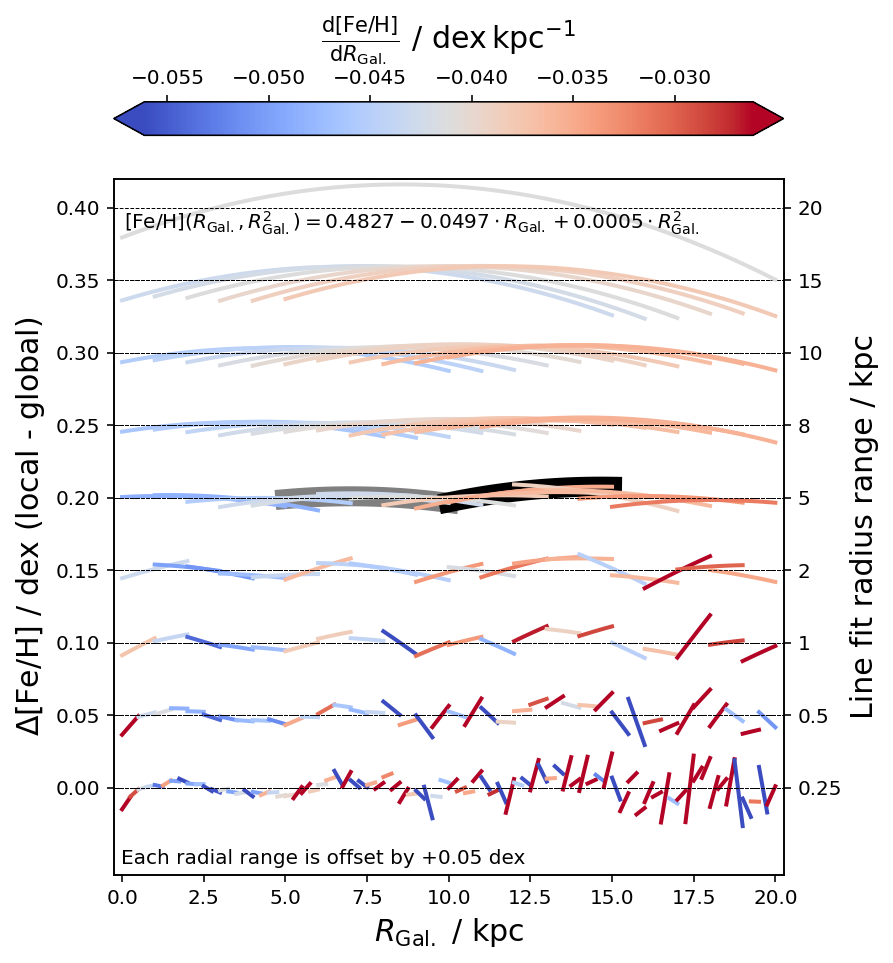

In [106]:
f, ax = plt.subplots(figsize=(6,8))

radial_ranges = [0.25, 0.5, 1, 2, 5, 8, 10, 15, 20]
radial_range_ticks = np.arange(len(radial_ranges)) * 0.05

norm = Normalize(vmin=model_global.coef_[0] - 0.015, vmax=model_global.coef_[0] + 0.015)
cmap = plt.get_cmap('coolwarm')

for radial_index, radial_range in enumerate(radial_ranges):

    increment = 1
    if radial_range < 1:
        increment = radial_range
    radial_mins = np.arange(0,nihao_R_max - radial_range+increment, increment)
    radial_maxs = np.arange(radial_range,nihao_R_max+increment, increment)
    
    
    for radial_range_index, (radial_min, radial_max) in enumerate(zip(radial_mins, radial_maxs)):


        in_radial_range = (
            (sim_stars['R'] >= radial_min) &
            (sim_stars['R'] <= radial_max) &
            (sim_stars['age'] <= nihao_age_max)
        )

        R    = sim_stars['R'][in_radial_range].reshape(-1, 1)  # Reshape for sklearn
        Fe_H = sim_stars['Fe_H'][in_radial_range]

        radial_model = LinearRegression()
        radial_model.fit(R, Fe_H)
        
        R_plot = np.linspace(radial_min, radial_max)
        Fe_H_plot = radial_model.predict(R_plot.reshape(-1,1)) - flattening_radial_metallicity_gradient(R_plot)
        
        if (radial_range == 5) & (radial_min == 5):
            ax.plot(
                R_plot,
                Fe_H_plot + radial_range_ticks[radial_index],
                color='grey', lw=10,
                zorder = 1
            )
        
        if (radial_range == 5) & (radial_min == 10):
            ax.plot(
                R_plot,
                Fe_H_plot + radial_range_ticks[radial_index],
                color='k', lw=10,
                zorder = 1
            )
        
        ax.plot(
            R_plot,
            Fe_H_plot + radial_range_ticks[radial_index],
            color=cmap(norm(radial_model.coef_[0])),
            zorder = 2, lw=2
        )
        
        if radial_range == 20:
            ax.text(0.05, radial_range_ticks[radial_index]-0.02,r'$\mathrm{[Fe/H]}(R_\mathrm{Gal.},R_\mathrm{Gal.}^2) = '+"{:.4f}".format(model_global_quadratic_results.params[0])+' '+"{:.4f}".format(model_global_quadratic_results.params[1])+'\cdot R_\mathrm{Gal.} + '+"{:.4f}".format(model_global_quadratic_results.params[2])+'\cdot R_\mathrm{Gal.}^2$', va='bottom')
            np.savetxt('tex_text/quadratic_gradient_global.tex',[r'$\mathrm{[Fe/H]}(R_\mathrm{Gal.},R_\mathrm{Gal.}^2) = '+"{:.4f}".format(model_global_quadratic_results.params[0])+' '+"{:.4f}".format(model_global_quadratic_results.params[1])+'\cdot R_\mathrm{Gal.} + '+"{:.4f}".format(model_global_quadratic_results.params[2])+'\cdot R_\mathrm{Gal.}^2$%'],fmt='%s')

        ax.axhline(radial_range_ticks[radial_index], lw=0.5, c='k', ls='dashed')

ax.set_ylim(-0.06,0.42)
ax.set_yticks(radial_range_ticks)
ax.set_ylabel('$\Delta \mathrm{[Fe/H]}$ / dex (local - global)')
ax.text(0.01,0.01,'Each radial range is offset by +0.05 dex',transform=ax.transAxes,ha='left',va='bottom',fontsize=10)
ax.set_xlabel(r'$R_\mathrm{Gal.}~/~\mathrm{kpc}$')

ax2 = ax.twinx()
ax2.set_yticks(radial_range_ticks)
ax2.set_yticklabels(radial_ranges)
ax2.set_ylim(ax.get_ylim())
ax2.set_ylabel('Line fit radius range / kpc')

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', location='top', extend='both')
cbar.set_label(label=r'$\frac{\mathrm{d[Fe/H]}}{\mathrm{d}R_\mathrm{Gal.}}~/~\mathrm{dex\,kpc^{-1}}$',labelpad=10)
ax.set_xlim(-0.25,20.25)

plt.savefig('figures/radial_range_impact_quadratic.png',dpi=300,bbox_inches='tight')
plt.show()
plt.close()

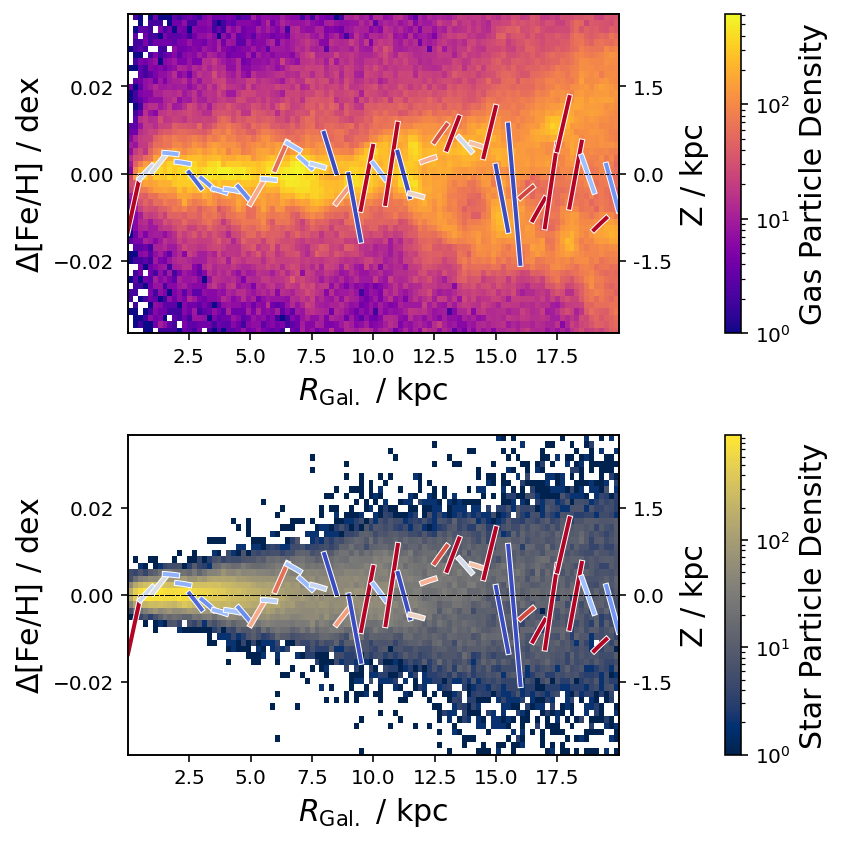

In [119]:
f, gs = plt.subplots(2,1,figsize=(6,6),sharey=True)

zmax = 2.75

ax = gs[0]
gas_within_Rmax = (
    (sim_gas['R'] < nihao_R_max) &
    (abs(sim_gas['z']) < zmax)
)

h = ax.hist2d(
    sim_gas['R'][gas_within_Rmax],
    sim_gas['z'][gas_within_Rmax]/75,
    bins = (100,50), norm=LogNorm(),
    cmin = 1, cmap = 'plasma',
    zorder = 1
);
cbar = plt.colorbar(h[-1],ax=ax, anchor=(1.0,0.5))
cbar.set_label('Gas Particle Density')

norm = Normalize(vmin=model_global.coef_[0] - 0.015, vmax=model_global.coef_[0] + 0.015)
cmap = plt.get_cmap('coolwarm')

radial_index = 0
radial_range = 0.5

increment = 1
if radial_range < 1:
    increment = radial_range
radial_mins = np.arange(0,nihao_R_max - radial_range+increment, increment)
radial_maxs = np.arange(radial_range,nihao_R_max+increment, increment)

for radial_range_index, (radial_min, radial_max) in enumerate(zip(radial_mins, radial_maxs)):


    in_radial_range = (
        (sim_stars['R'] >= radial_min) &
        (sim_stars['R'] <= radial_max) &
        (sim_stars['age'] <= nihao_age_max)
    )

    R    = sim_stars['R'][in_radial_range].reshape(-1, 1)  # Reshape for sklearn
    Fe_H = sim_stars['Fe_H'][in_radial_range]

    radial_model = LinearRegression()
    radial_model.fit(R, Fe_H)

    R_plot = np.linspace(radial_min, radial_max)
    Fe_H_plot = radial_model.predict(R_plot.reshape(-1,1)) - flattening_radial_metallicity_gradient(R_plot)

    ax.plot(
        R_plot,
        Fe_H_plot,
        color='w',
        zorder = 2, lw=3, 
    )
    ax.plot(
        R_plot,
        Fe_H_plot,
        color=cmap(norm(radial_model.coef_[0])),
        zorder = 2, lw=2
    )

    if radial_range == 15:
        ax.text(0.05, radial_range_ticks[radial_index]+0.02,r'$\mathrm{[Fe/H]}(R_\mathrm{Gal.},R_\mathrm{Gal.}^2) = '+"{:.4f}".format(model_global_quadratic_results.params[0])+' '+"{:.4f}".format(model_global_quadratic_results.params[1])+'\cdot R_\mathrm{Gal.} + '+"{:.4f}".format(model_global_quadratic_results.params[2])+'\cdot R_\mathrm{Gal.}^2$', va='bottom')
        np.savetxt('tex_text/quadratic_gradient_global.tex',[r'$\mathrm{[Fe/H]}(R_\mathrm{Gal.},R_\mathrm{Gal.}^2) = '+"{:.4f}".format(model_global_quadratic_results.params[0])+' '+"{:.4f}".format(model_global_quadratic_results.params[1])+'\cdot R_\mathrm{Gal.} + '+"{:.4f}".format(model_global_quadratic_results.params[2])+'\cdot R_\mathrm{Gal.}^2$%'],fmt='%s')

    ax.axhline(0, lw=0.5, c='k', ls='dashed')
    
ticks = ax.get_yticks()
    
z_ticks = np.round(ticks * 75,2)
ax2 = ax.twinx()
ax2.set_yticks(ticks)
ax2.set_yticklabels(z_ticks)
ax2.set_ylim(ax.get_ylim())
ax2.set_ylabel('Z / kpc')
ax.set_ylabel(r'$\Delta \mathrm{[Fe/H]}~/~\mathrm{dex}$')
ax.set_xlabel(r'$R_\mathrm{Gal.}~/~\mathrm{kpc}$')

ax = gs[1]
gas_within_Rmax = (
    (sim_stars['R'] < nihao_R_max) &
    (abs(sim_stars['z']) < zmax) &
    (sim_stars['age'] < nihao_age_max)
)

h = ax.hist2d(
    sim_stars['R'][gas_within_Rmax],
    sim_stars['z'][gas_within_Rmax]/75,
    bins = (100,50), norm=LogNorm(),
    cmin = 1, cmap = 'cividis',
    zorder = 1
);
cbar = plt.colorbar(h[-1],ax=ax, anchor=(1.0,0.5))
cbar.set_label('Star Particle Density')

norm = Normalize(vmin=model_global.coef_[0] - 0.015, vmax=model_global.coef_[0] + 0.015)
cmap = plt.get_cmap('coolwarm')

for radial_range_index, (radial_min, radial_max) in enumerate(zip(radial_mins, radial_maxs)):


    in_radial_range = (
        (sim_stars['R'] >= radial_min) &
        (sim_stars['R'] <= radial_max) &
        (sim_stars['age'] <= nihao_age_max)
    )

    R    = sim_stars['R'][in_radial_range].reshape(-1, 1)  # Reshape for sklearn
    Fe_H = sim_stars['Fe_H'][in_radial_range]

    radial_model = LinearRegression()
    radial_model.fit(R, Fe_H)

    R_plot = np.linspace(radial_min, radial_max)
    Fe_H_plot = radial_model.predict(R_plot.reshape(-1,1)) - flattening_radial_metallicity_gradient(R_plot)

    ax.plot(
        R_plot,
        Fe_H_plot,
        color='w',
        zorder = 2, lw=3, 
    )
    ax.plot(
        R_plot,
        Fe_H_plot,
        color=cmap(norm(radial_model.coef_[0])),
        zorder = 2, lw=2
    )

    if radial_range == 15:
        ax.text(0.05, radial_range_ticks[radial_index]+0.02,r'$\mathrm{[Fe/H]}(R_\mathrm{Gal.},R_\mathrm{Gal.}^2) = '+"{:.4f}".format(model_global_quadratic_results.params[0])+' '+"{:.4f}".format(model_global_quadratic_results.params[1])+'\cdot R_\mathrm{Gal.} + '+"{:.4f}".format(model_global_quadratic_results.params[2])+'\cdot R_\mathrm{Gal.}^2$', va='bottom')
        np.savetxt('tex_text/quadratic_gradient_global.tex',[r'$\mathrm{[Fe/H]}(R_\mathrm{Gal.},R_\mathrm{Gal.}^2) = '+"{:.4f}".format(model_global_quadratic_results.params[0])+' '+"{:.4f}".format(model_global_quadratic_results.params[1])+'\cdot R_\mathrm{Gal.} + '+"{:.4f}".format(model_global_quadratic_results.params[2])+'\cdot R_\mathrm{Gal.}^2$%'],fmt='%s')

    ax.axhline(0, lw=0.5, c='k', ls='dashed')
    
ticks = ax.get_yticks()
    
z_ticks = np.round(ticks * 75,2)
ax2 = ax.twinx()
ax2.set_yticks(ticks)
ax2.set_yticklabels(z_ticks)
ax2.set_ylim(ax.get_ylim())
ax2.set_ylabel('Z / kpc')
ax.set_ylabel(r'$\Delta \mathrm{[Fe/H]}~/~\mathrm{dex}$')
ax.set_xlabel(r'$R_\mathrm{Gal.}~/~\mathrm{kpc}$')

plt.tight_layout()
plt.savefig('figures/overlap_local_variation_gas.png',dpi=300,bbox_inches='tight')
plt.show()
plt.close()


## 3.3 Coherence of the gradient with position

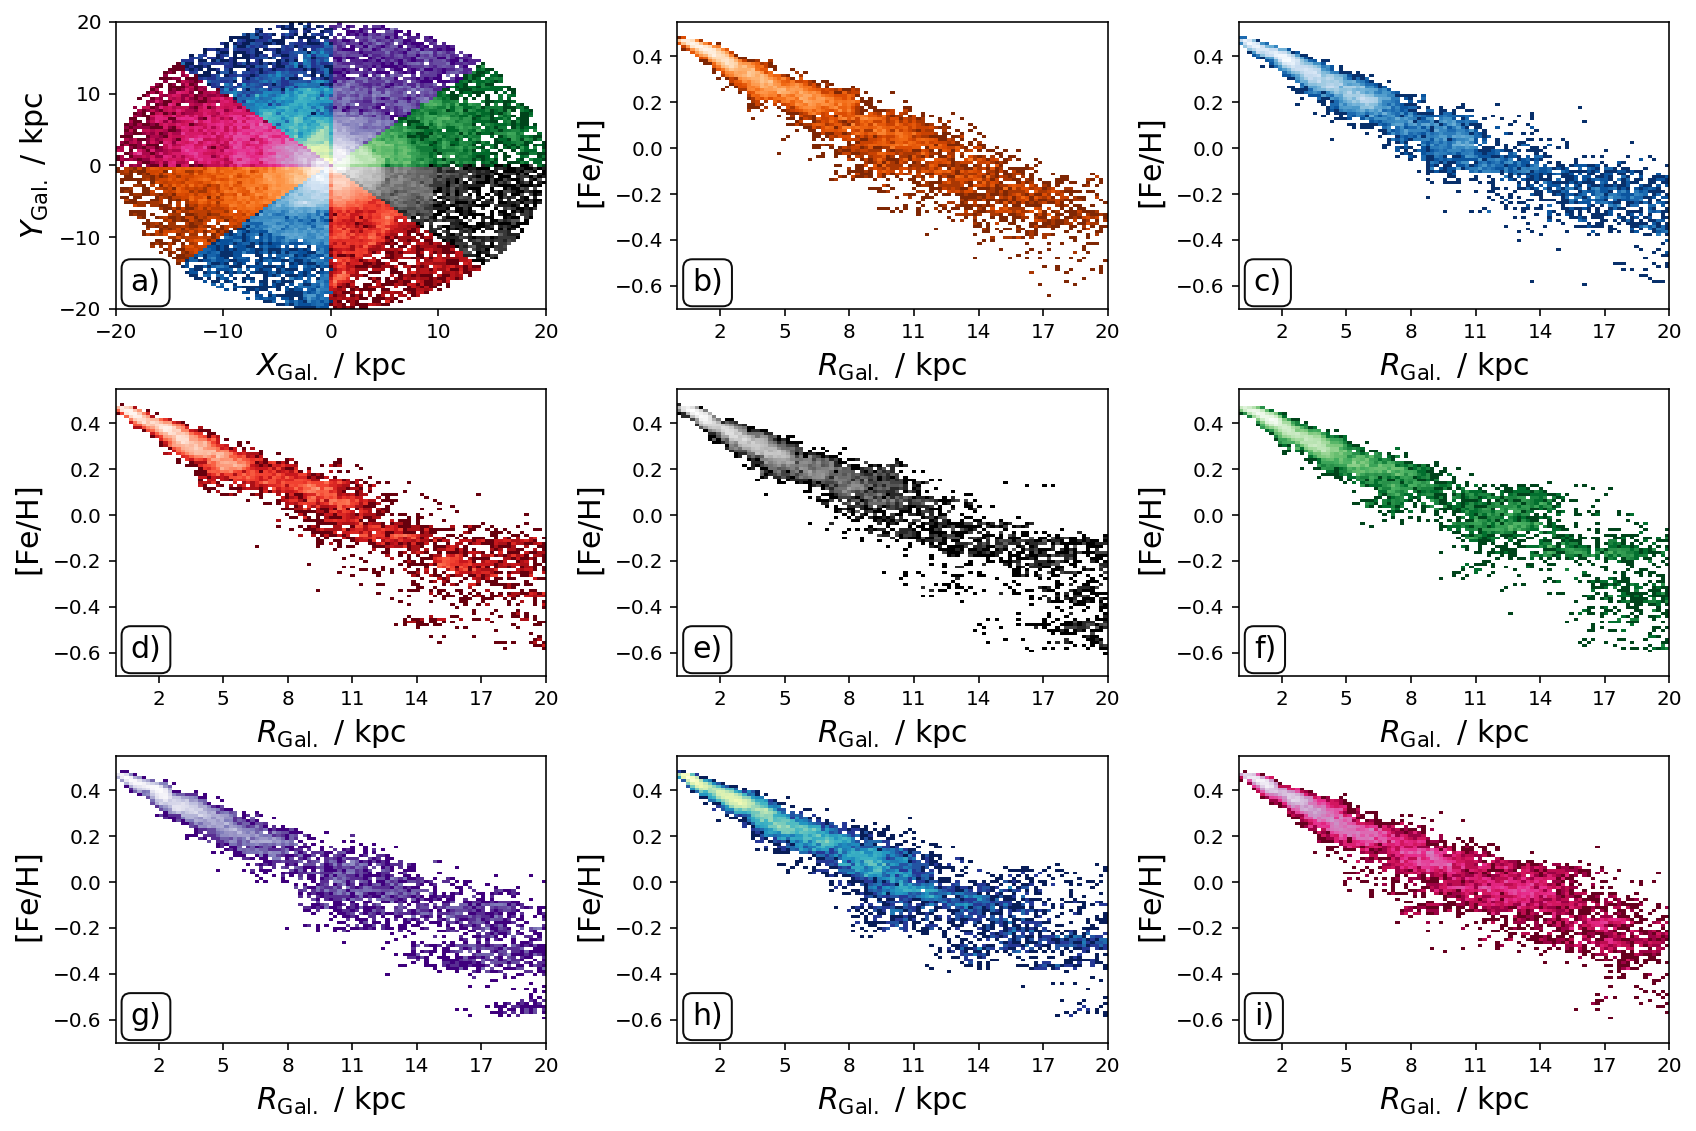

In [12]:
f, axes = plt.subplots(3,3,figsize=(12,8))
axes = axes.flatten()

ax = axes[0]
ax.text(0.035,0.04,panels[0],fontsize=15,transform=ax.transAxes,va='bottom',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.set_xlabel(r'$X_\mathrm{Gal.}~/~\mathrm{kpc}$')
ax.set_ylabel(r'$Y_\mathrm{Gal.}~/~\mathrm{kpc}$')

phi_angle = 45


colormaps = ['Oranges_r', 'Blues_r', 'Reds_r', 'Greys_r', 'Greens_r', 'Purples_r', 'YlGnBu_r', 'PuRd_r']

for phi_index in range(int(360/phi_angle)):

    in_phi_range = (
        (sim_stars['R'] < nihao_R_max) &
        (sim_stars['age'] < nihao_age_max) &
        (sim_stars['phi'] + np.pi > ((phi_index * phi_angle / 360) * 2*np.pi)) &
        (sim_stars['phi'] + np.pi <= (((phi_index+1) * phi_angle / 360) * 2*np.pi))
    )
    
    # Plot position
    ax = axes[0]
    ax.hist2d(
        sim_stars['x'][in_phi_range],
        sim_stars['y'][in_phi_range],
        cmin = 1, cmap = colormaps[phi_index],
        norm = LogNorm(),
        bins = (np.linspace(-20,20,100),np.linspace(-20,20,100))
    )
    
    ax = axes[phi_index+1]
    ax.text(0.035,0.04,panels[phi_index+1],fontsize=15,transform=ax.transAxes,va='bottom',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
    ax.set_xlabel(r'$R_\mathrm{Gal.}~/~\mathrm{kpc}$')
    ax.set_xticks([2,5,8,11,14,17,20])
    ax.set_ylabel(r'$\mathrm{[Fe/H]}$')
    
    ax.hist2d(
        sim_stars['R'][in_phi_range],
        sim_stars['Fe_H'][in_phi_range],
        cmin = 1, cmap = colormaps[phi_index],
        norm = LogNorm(),
        bins = (np.linspace(0,20,100),np.linspace(-0.70,0.55,100))
    )

plt.tight_layout(w_pad=0,h_pad=0)
plt.savefig('figures/radial_metallicity_gradients_mw_in_angles.png',dpi=300,bbox_inches='tight')
plt.show()
plt.close()

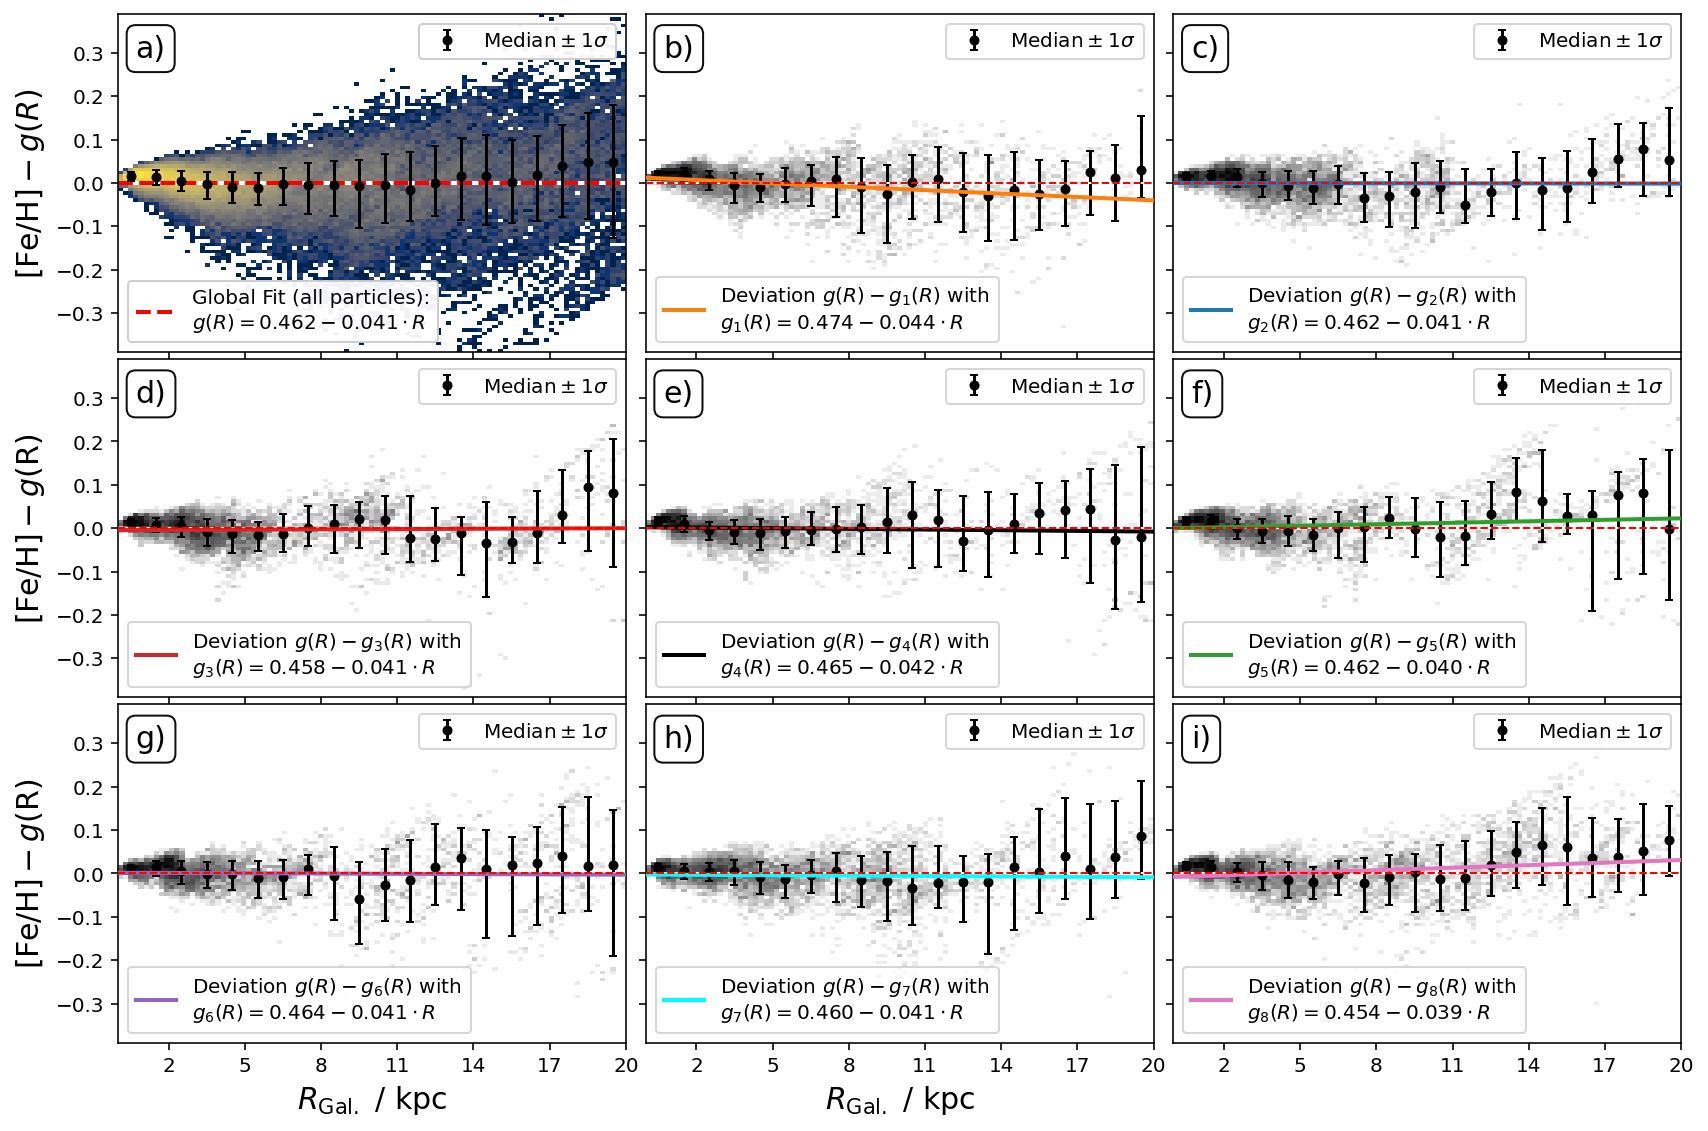

In [97]:
f, axes = plt.subplots(3,3,figsize=(12,8), sharex=True,sharey=True)

axes = axes.flatten()

ax = axes[0]
ax.text(0.035,0.94,panels[0],fontsize=15,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.set_ylabel(r'$\mathrm{[Fe/H]} - g(R)$')

feh_minmax = 0.39

ax.hist2d(
    sim_stars['R'][in_range],
    sim_stars['Fe_H_residuals'][in_range],
    cmin = 1, cmap = 'cividis',
    norm = LogNorm(),
    bins = (np.linspace(0,20,100),np.linspace(-feh_minmax,feh_minmax,100)),
    zorder = 1
)

R_line = np.linspace(0,nihao_R_max,100).reshape(-1, 1)
# Fe_H_line = model_global.predict(R_line)
Fe_H_line = np.zeros(len(R_line))

ax.plot(
    R_line,
    Fe_H_line,
    c = 'w',lw=2,
    zorder = 2
)
s2 = ax.plot(
    R_line,
    Fe_H_line,
    c = 'r',lw=2,ls='dashed',
    zorder = 2, label = 'Global Fit (all particles):\n'+r'$g(R) = '+"{:.3f}".format(model_global.intercept_)+' '+"{:.3f}".format(model_global.coef_[0])+'\cdot R$'
)

R_bins = np.linspace(0,nihao_R_max,21)

for R_index, (R_bin_min, R_bin_max) in enumerate(zip(R_bins[:-1],R_bins[1:])):

    in_R = (
        (sim_stars['R'] > R_bin_min) &
        (sim_stars['R'] <= R_bin_max) &
        (sim_stars['age'] < 1.0)
    )

    perc = np.percentile(sim_stars['Fe_H_residuals'][in_R],q=[16,50,84])

    if R_index == 0:
        label = r'$\mathrm{Median}\pm 1 \sigma$'
    else:
        label = '_nolegend_'

    s = ax.errorbar(
        0.5*(R_bin_min+R_bin_max),
        perc[1],
        yerr = [[perc[1]-perc[0]],[perc[2]-perc[1]]],
        c = 'k',ms=4,fmt='o',label = label,
        capsize=2, zorder = 3
    )
    if R_index == 0:
        legend_labels = []
        legend_labels.append(s)

legend_labels.append(s2)
        
legend2 = ax.legend(handles=legend_labels[:1], loc='upper right',fontsize=10, framealpha=0.95)
ax.add_artist(legend2)

ax.legend(handles=legend_labels[1], loc='lower left',fontsize=10, framealpha=0.95)

# colormaps = ['Oranges_r', 'Blues_r', 'Reds_r', 'Greys_r', 'Greens_r', 'Purples_r', 'YlGnBu_r', 'PuRd_r']
colors = ['C1', 'C0', 'C3', 'k', 'C2', 'C4', 'cyan','C6']

phi_angle = 45

for phi_index in range(int(360/phi_angle)):
    
    if phi_index in [3,6]:
        ax.set_ylabel(r'$\mathrm{[Fe/H]} - g(\mathrm{R})$')
    if phi_index in [6,7,8]:
        ax.set_xlabel(r'$R_\mathrm{Gal.}~/~\mathrm{kpc}$')
        ax.set_xticks([2,5,8,11,14,17,20])
    
    ax = axes[phi_index+1]
    ax.text(0.035,0.94,panels[phi_index+1],fontsize=15,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))

    in_phi_range = (
        (sim_stars['R'] < nihao_R_max) &
        (sim_stars['age'] < 1.0) &
        (sim_stars['phi'] + np.pi > ((phi_index * phi_angle / 360) * 2*np.pi)) &
        (sim_stars['phi'] + np.pi <= (((phi_index+1) * phi_angle / 360) * 2*np.pi))
    )
    
    R_bins = np.linspace(0,nihao_R_max,21)
    
    legend_labels = []
    
    for R_index, (R_bin_min, R_bin_max) in enumerate(zip(R_bins[:-1],R_bins[1:])):

        in_phi_range_R = (
            (sim_stars['R'] > R_bin_min) &
            (sim_stars['R'] <= R_bin_max) &
            (sim_stars['age'] < 1.0) &
            (sim_stars['phi'] + np.pi > ((phi_index * phi_angle / 360) * 2*np.pi)) &
            (sim_stars['phi'] + np.pi <= (((phi_index+1) * phi_angle / 360) * 2*np.pi))
        )
        
        perc = np.percentile(sim_stars['Fe_H_residuals'][in_phi_range_R],q=[16,50,84])
        
        if R_index == 0:
            label = r'$\mathrm{Median}\pm 1 \sigma$'
        else:
            label = '_nolegend_'
            
        s = ax.errorbar(
            0.5*(R_bin_min+R_bin_max),
            perc[1],
            yerr = [[perc[1]-perc[0]],[perc[2]-perc[1]]],
            c = 'k',ms=4,fmt='o',label = label,
            capsize=2, zorder = 2
        )
        if R_index==0:
            legend_labels.append(s)

    # Fit a linear regression model
    R    = sim_stars['R'][in_phi_range].reshape(-1, 1)  # Reshape for sklearn
    Fe_H = sim_stars['Fe_H'][in_phi_range]

    model_sector = LinearRegression()
    model_sector.fit(R, Fe_H)

    s = ax.plot(
        R_line,
        model_sector.predict(R_line) - model_global.predict(R_line),
        c = colors[phi_index],lw=2,
        zorder = 3, label = r'Deviation $g(R) - g_'+str(phi_index+1)+'(R)$ with \n'+r'$g_'+str(phi_index+1)+'(R) = '+"{:.3f}".format(model_sector.intercept_)+' '+"{:.3f}".format(model_sector.coef_[0])+'\cdot R$'
    )
    legend_labels.append(s)
    
    legend2 = ax.legend(handles=legend_labels[:1], loc='upper right',fontsize=10)
    ax.add_artist(legend2)
    ax.legend(handles=legend_labels[1], loc='lower left',fontsize=10)

    ax.hist2d(
        sim_stars['R'][in_phi_range],
        sim_stars['Fe_H'][in_phi_range] - model_global.predict(R),
        cmin = 1, cmap = 'Greys',
        norm = LogNorm(),
        bins = (np.linspace(0,20,100),np.linspace(-feh_minmax,feh_minmax,100)),
        zorder = 1
    )
    
    ax.plot(
        R_line,
        Fe_H_line,
        c = 'w',lw=1,
        zorder = 2
    )
    ax.plot(
        R_line,
        Fe_H_line,
        c = 'r',lw=1,ls='dashed',
        zorder = 3
    )

plt.tight_layout(w_pad=0,h_pad=0)
plt.savefig('figures/linear_radial_metallicity_gradients_mw_in_angles.png',dpi=300,bbox_inches='tight')
plt.show()
plt.close()

0


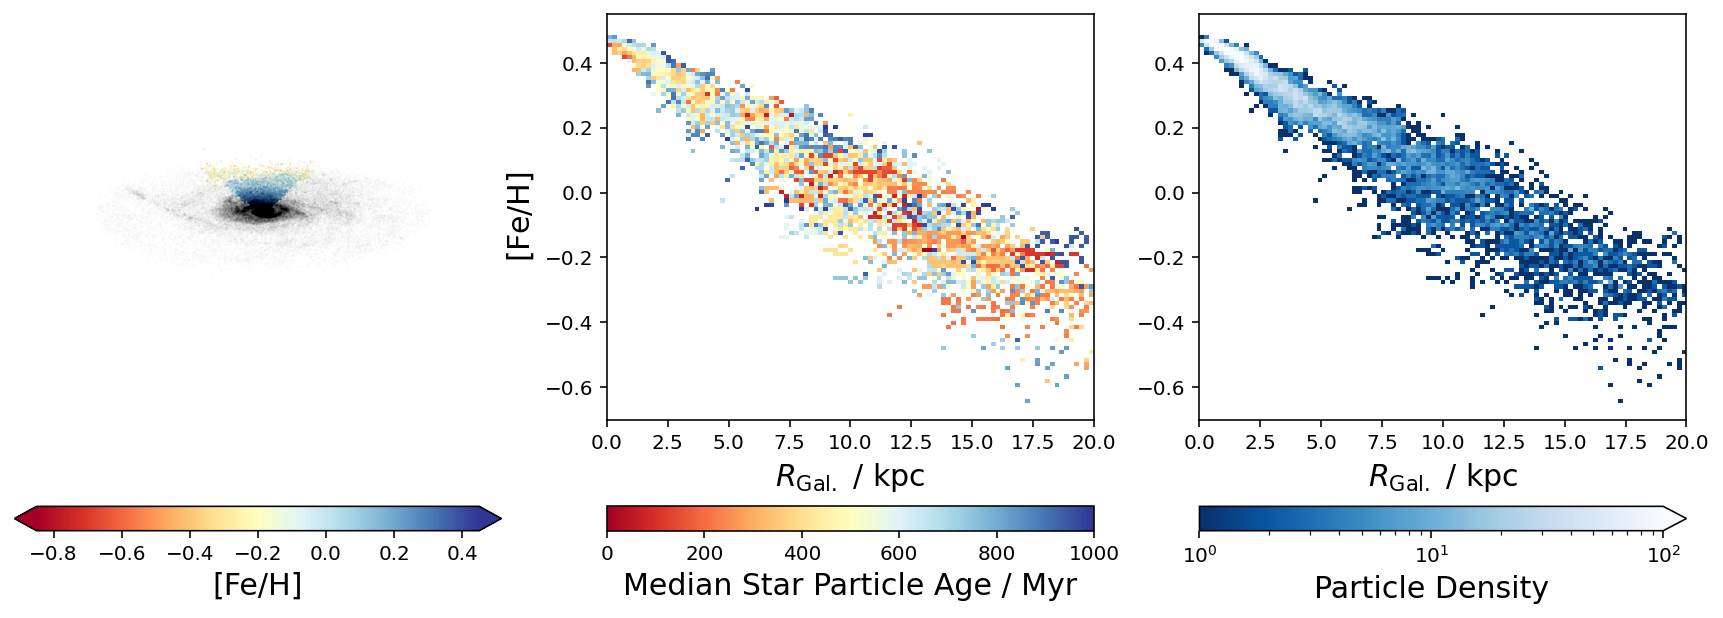

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350


In [14]:
phi_angle = 45

for phi_index in np.arange(0,360,5):

    if phi_index%10==0:
        print(phi_index)
    
    phi_min = phi_index
    phi_max = phi_index + phi_angle
    if phi_max <= 360:
        within_phi = (
            (sim_stars['phi_angle'] >  phi_min) &
            (sim_stars['phi_angle'] <= phi_max)
        )
    if phi_max > 360:
        within_phi = (
            (sim_stars['phi_angle'] >  phi_min) |
            (sim_stars['phi_angle'] +360 <= phi_max)
        )

    sim_within_20kpc = (
        (sim_stars['R'] < nihao_R_max) &
        (sim_stars['age'] < nihao_age_max)
    )
    
    in_phi_range = (
        (sim_stars['R'] < nihao_R_max) &
        (sim_stars['age'] < nihao_age_max) &
        within_phi
    )

    fig = plt.figure(figsize=(12, 4.5))
    gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1])

    # Create left subplot (2/3 of the width)
    ax = fig.add_subplot(gs[0], projection='3d')

    s = ax.scatter(
        sim_stars['x'][sim_within_20kpc],
        sim_stars['y'][sim_within_20kpc],
        sim_stars['z'][sim_within_20kpc],
        c='k',zorder=1,
        s = 1,
        lw = 0,
        alpha = 0.01
    )
    s = ax.scatter(
        sim_stars['x'][in_phi_range],
        sim_stars['y'][in_phi_range],
        sim_stars['z'][in_phi_range],
        c = sim_stars['Fe_H'][in_phi_range],
        cmap = 'RdYlBu',
        vmin = -0.85, vmax = 0.45,
        s = 1, lw = 0, zorder=2
    )
    plt.colorbar(s, ax=ax, label='[Fe/H]',orientation='horizontal',extend='both')
    ax.set_xlim(-15,15)
    ax.set_ylim(-15,15)
    ax.set_zlim(-15,15)

    # Remove grid and axes
    ax.grid(False)
    ax.set_axis_off()
    ax.view_init(elev=20, azim=20)

    # Create right subplot (1/3 of the width)
    ax2 = fig.add_subplot(gs[1])

    stats, x_edge, y_edge, _ = binned_statistic_2d(
        sim_stars['R'][in_phi_range], 
        sim_stars['Fe_H'][in_phi_range],
        sim_stars['age'][in_phi_range]*1000, statistic='median',
        bins=(np.linspace(0,nihao_R_max,100),np.linspace(-0.70,0.55,100)))

    pcm = ax2.pcolormesh(x_edge, y_edge, stats.T, shading='auto', cmap='RdYlBu', vmin = 0, vmax = 1000*nihao_age_max)
    plt.colorbar(pcm, ax=ax2, label='Median Star Particle Age / Myr',orientation='horizontal')
    ax2.set_xlabel(r'$R_\mathrm{Gal.}~/~\mathrm{kpc}$')
    ax2.set_ylabel(r'$\mathrm{[Fe/H]}$')

    # Create right subplot (1/3 of the width)
    ax2 = fig.add_subplot(gs[2])

    h = ax2.hist2d(
        sim_stars['R'][in_phi_range], 
        sim_stars['Fe_H'][in_phi_range],
        bins=(np.linspace(0,nihao_R_max,100),np.linspace(-0.70,0.55,100)),
        cmin = 1, cmap='Blues_r', norm=LogNorm(vmin=1,vmax=100)
    )

    plt.colorbar(h[-1], ax=ax2, label='Particle Density',orientation='horizontal',extend='max')
    ax2.set_xlabel(r'$R_\mathrm{Gal.}~/~\mathrm{kpc}$')

    plt.tight_layout(w_pad=0)
    
    if phi_index < 10:
        st = '00'+str(phi_index)
    elif phi_index < 100:
        st = '0'+str(phi_index)
    else:
        st = str(phi_index)
    
    plt.savefig('figures/xyz_rfeh/xyz_rfeh_'+str(st)+'.png',dpi=200,bbox_inches='tight')
    if phi_index==0:
        plt.show()
    plt.close()

In [15]:
# make a GIF!
os.system('convert -delay 10 figures/xyz_rfeh/xyz_rfeh_*.png figures/xyz_rfeh.gif');

## 3.4 Coherence of the gradient with age

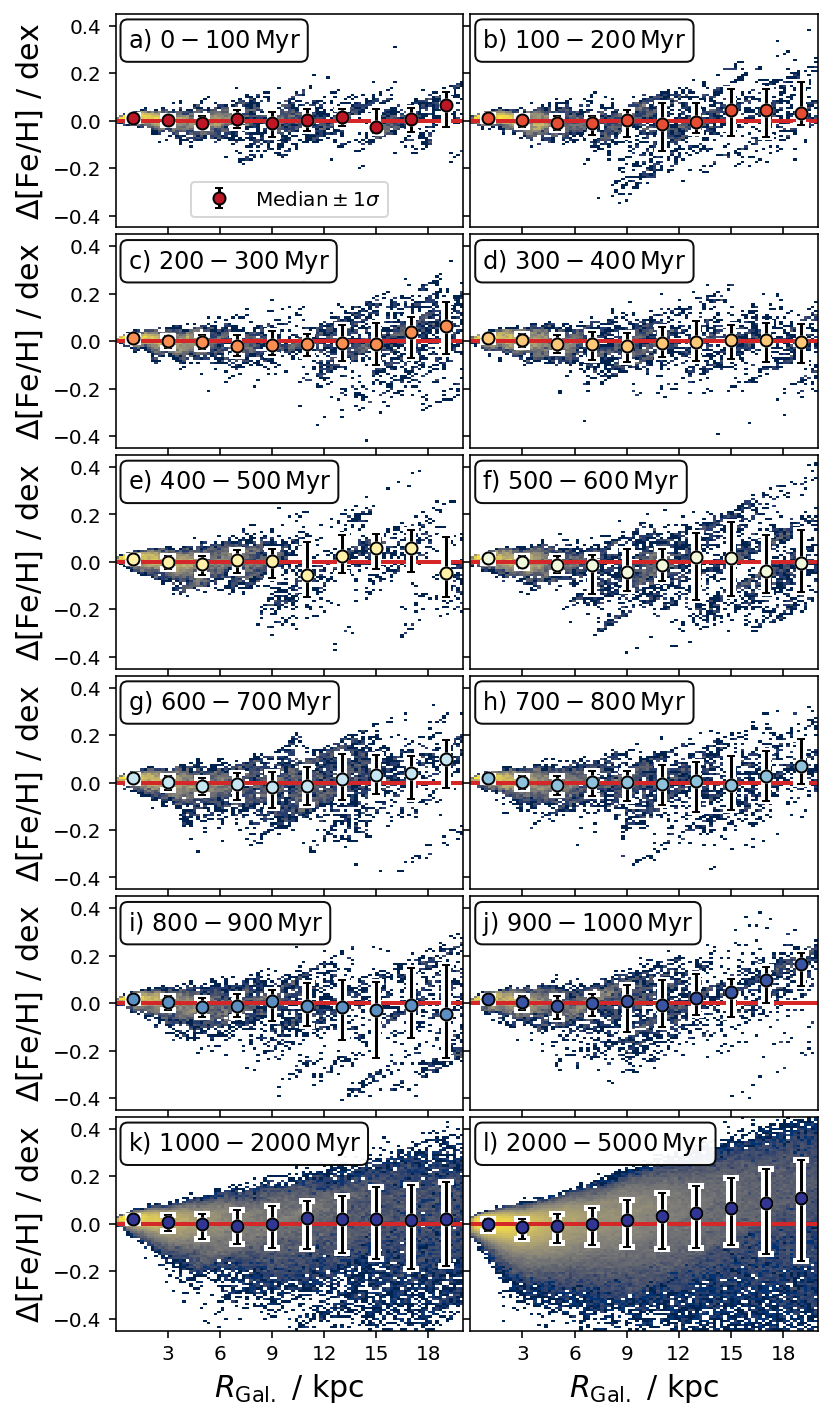

In [94]:
age_bins = 100 # Myr
ages = np.concatenate((np.arange(0,1000+age_bins, age_bins),[2000,5000]))

R_bins = np.linspace(0,nihao_R_max,11)

norm = Normalize(vmin=0, vmax=1000)
cmap = plt.get_cmap('RdYlBu')

f, axes = plt.subplots(6,2,figsize=(6,10),sharex=True,sharey=True)
axes = axes.flatten()

overall_max_scatter = []

for age_index, (min_age, max_age) in enumerate(zip(ages[:-1],ages[1:])):

    ax = axes[age_index]
    ax.text(0.035,0.94,panels[age_index]+r' $'+str(min_age)+' - '+str(max_age)+'\,\mathrm{Myr}$',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))

    in_age_range = (
        (sim_stars['R'] < nihao_R_max) &
        (sim_stars['age'] * 1000 >= min_age) &
        (sim_stars['age'] * 1000 < max_age)
    )
    
    ax.hist2d(
        sim_stars['R'][in_age_range],
        sim_stars['Fe_H_residuals'][in_age_range],
        bins = (np.linspace(0,nihao_R_max,100),np.linspace(-0.45,0.45,100)),
        cmin = 1, cmap = 'cividis', norm=LogNorm()
    )
    
    if age_index%2==0:
        ax.set_ylabel(r'$\Delta \mathrm{[Fe/H]}~/~\mathrm{dex}$')
    if min_age in ages[-3:]:
        ax.set_xticks([3,6,9,12,15,18])
        ax.set_xlabel(r'$R_\mathrm{Gal.}~/~\mathrm{kpc}$')
    
    max_scatter = 0
    
    for R_index, (R_bin_min, R_bin_max) in enumerate(zip(R_bins[:-1],R_bins[1:])):

        in_R = (
            (sim_stars['R'] > R_bin_min) &
            (sim_stars['R'] <= R_bin_max) &
            (sim_stars['age'] * 1000 >= min_age) &
            (sim_stars['age'] * 1000 < max_age)
        )

        perc = np.percentile(sim_stars['Fe_H_residuals'][in_R],q=[16,50,84])

        if (age_index == 0) & (R_index == 0):
            label = r'$\mathrm{Median}\pm 1 \sigma$'
        else:
            label = '_nolegend_'

        ax.axhline(0.0, lw=2, c='C3',zorder=1)
        s = ax.errorbar(
            0.5*(R_bin_min+R_bin_max),
            perc[1],
            yerr = [[perc[1]-perc[0]],[perc[2]-perc[1]]],
            color = cmap(norm(0.5*(min_age+max_age))),ms=6,fmt='o',
            capsize=4, capthick=3, zorder = 2, ecolor='w', markeredgecolor='w', linewidth=5
        )
            
        s = ax.errorbar(
            0.5*(R_bin_min+R_bin_max),
            perc[1],
            yerr = [[perc[1]-perc[0]],[perc[2]-perc[1]]],
            color = cmap(norm(0.5*(min_age+max_age))),ms=6,fmt='o',label = label,
            capsize=2, zorder = 2, ecolor='k', markeredgecolor='k', linewidth=1.5
        )
        if (age_index == 0) & (R_index == 0):
            ax.legend(loc='lower center',fontsize=10)

        max_scatter_candidate = np.round(0.5*(perc[2]-perc[0]),3)
        if max_scatter_candidate > max_scatter:
            max_scatter = max_scatter_candidate
    if max_age <= 1000:
        overall_max_scatter.append(max_scatter)

plt.tight_layout(w_pad=0, h_pad=0)
plt.savefig('figures/scatter_with_increasing_age.png',dpi=300,bbox_inches='tight')
plt.show()
plt.close()

The maximum scatter in radius bins varies between $0.073\,\mathrm{dex}$ and $0.195\,\mathrm{dex}$ across the $0..0.1..1.0\,\mathrm{Gyr}$ bins.%


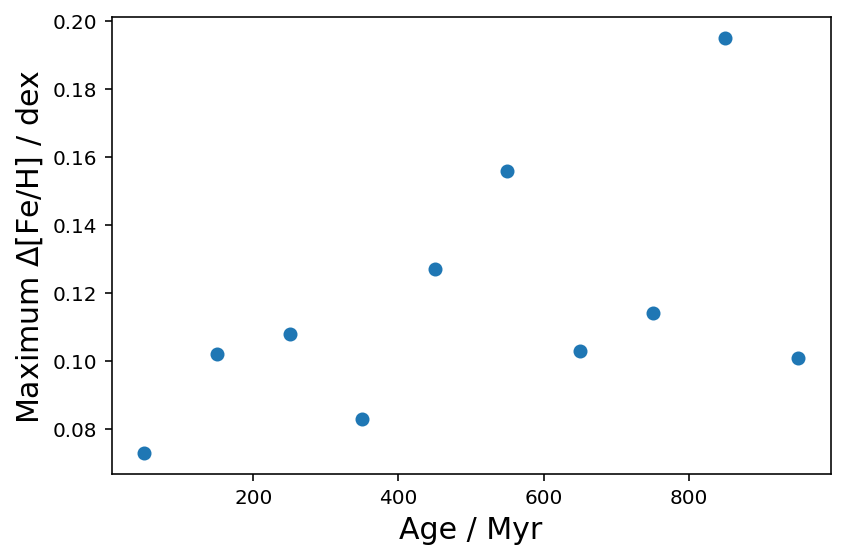

In [17]:
text = 'The maximum scatter in radius bins varies between $'+str(np.min(overall_max_scatter))+r'\,\mathrm{dex}$ and $'+str(np.max(overall_max_scatter))+r'\,\mathrm{dex}$ across the $0..0.1..1.0\,\mathrm{Gyr}$ bins.%'
print(text)
np.savetxt('tex_text/maximum_scatter_ages.tex',[text],fmt='%s')

f, ax = plt.subplots()
ax.scatter(ages[:-3]+0.5*age_bins,overall_max_scatter)
ax.set_xlabel('Age / Myr')
ax.set_ylabel(r'Maximum $\Delta \mathrm{[Fe/H]}~/~\mathrm{dex}$')
plt.tight_layout()


# 4 Discussion

## 2.1 Observations

In [18]:
# GALAH DR3 (Buder et al., 2021)
galah_dr3_main     = Table.read('data/GALAH_DR3_main_allstar_v2.fits')
galah_dr3_dynamics = Table.read('data/GALAH_DR3_VAC_dynamics_v2.fits')
galah_dr3 = join(galah_dr3_main, galah_dr3_dynamics, keys='sobject_id',metadata_conflicts='silent')
galah_dr3 = galah_dr3[~galah_dr3['dr2_source_id'].mask]
galah_dr3['e_R_Rzphi'] = 0.5/1.645*(galah_dr3['R_Rzphi_95'] - galah_dr3['R_Rzphi_5']) # 5th-95th cover 2sigma * 1.645
galah_dr3['e_z_Rzphi'] = 0.5/1.645*(galah_dr3['z_Rzphi_95'] - galah_dr3['z_Rzphi_5']) # convert to 1 sigma
galah_dr3 = galah_dr3[(
    (galah_dr3['flag_sp'] == 0) &
    (galah_dr3['flag_fe_h'] == 0)
)]
galah_dr3 = galah_dr3[['dr2_source_id','fe_h','e_fe_h','R_Rzphi','e_R_Rzphi','z_Rzphi','e_z_Rzphi']]


In [19]:
# APOGEE DR17 (SDSS Collaboration et al., 2022)
apogee_dr17 = Table.read('data/allStar-dr17-synspec_rev1.fits',1)
apogee_dr17['dr2_source_id'] = apogee_dr17['GAIAEDR3_SOURCE_ID']
apogee_dr17 = apogee_dr17[(
    (apogee_dr17['ASPCAPFLAG'] < 2**23) &
    (apogee_dr17['FE_H_FLAG'] == 0)
)]
apogee_dr17 = apogee_dr17[['dr2_source_id','RA','GAIAEDR3_PMRA','DEC','GAIAEDR3_PMDEC','GAIAEDR3_R_MED_PHOTOGEO','VHELIO_AVG','FE_H','FE_H_ERR','FE_H_FLAG',]]
# rename some keywords
apogee_dr17.rename_column('FE_H','fe_h')
apogee_dr17.rename_column('FE_H_ERR','e_fe_h')

In [20]:
# Cantat-Gaudin et al. (2020) Open Cluster Membership Catalogue
cg20 = Table.read('data/CantatGaudin_2020_AandA_640_1.fits')
cg20['dr2_source_id'] = cg20['GaiaDR2']
cg20 = cg20[~cg20['logAge'].mask]

In [21]:
# Open Cluster Members in GALAH DR3
oc_galah_dr3 = join(cg20, galah_dr3, keys = 'dr2_source_id')

# Open Cluster Members in GALAH DR3
oc_apogee_dr17 = join(cg20, apogee_dr17, keys = 'dr2_source_id')

In [22]:
unique_oc_galah_dr3, unique_oc_galah_dr3_index = np.unique(oc_galah_dr3['Cluster'], return_index=True)

oc_galah_dr3_unique = Table()
oc_galah_dr3_unique['Cluster'] = unique_oc_galah_dr3
oc_galah_dr3_unique['Age_Myr'] = 10**(oc_galah_dr3['logAge'][unique_oc_galah_dr3_index]-6)

for key_index, key in enumerate(['R_Rzphi','z_Rzphi','fe_h']):
    
    values_median = []
    values_scatter = []
    values_numbers = []
    
    for cluster in unique_oc_galah_dr3:
        
        in_cluster_unflagged = (
            (oc_galah_dr3['Cluster'] == cluster)
        )
        
        if len(oc_galah_dr3[key][in_cluster_unflagged]) > 3:
            values_median.append(np.median(oc_galah_dr3[key][in_cluster_unflagged]))
            values_scatter.append(
                np.std(oc_galah_dr3[key][in_cluster_unflagged])**2+
                np.median(oc_galah_dr3['e_'+key][in_cluster_unflagged])**2
            )
            if key_index == 0: values_numbers.append(len(oc_galah_dr3[key][in_cluster_unflagged]))
            
        else:
            values_median.append(np.nan)
            values_scatter.append(np.nan)
            if key_index == 0: values_numbers.append(0)
            
    if key_index == 0: oc_galah_dr3_unique['numbers'] = np.array(values_numbers,dtype=int)
    oc_galah_dr3_unique[key+'_median'] = np.array(values_median,dtype=np.float32)
    oc_galah_dr3_unique[key+'_scatter'] = np.array(values_scatter,dtype=np.float32)

oc_galah_dr3_unique = oc_galah_dr3_unique[np.isfinite(oc_galah_dr3_unique['R_Rzphi_median'])]
oc_galah_dr3_unique.sort('z_Rzphi_median')
oc_galah_dr3_unique[oc_galah_dr3_unique['Age_Myr'] < 1000]

/Users/buder/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Cluster,Age_Myr,numbers,R_Rzphi_median,R_Rzphi_scatter,z_Rzphi_median,z_Rzphi_scatter,fe_h_median,fe_h_scatter
bytes17,float32,int64,float32,float32,float32,float32,float32,float32
Blanco_1,104.71297,42,8.168409,2.6280757e-06,-0.20497741,1.1908915e-05,-0.05085206,0.009485066
NGC_1901,891.25055,17,8.16489,8.135366e-06,-0.20374805,5.6844215e-06,-0.28130436,0.26408595
Mamajek_4,371.53497,11,7.802387,5.5226457e-05,-0.10748461,4.271473e-06,0.027851105,0.029473562
Gulliver_6,16.595861,8,8.566823,7.9937956e-05,-0.1061165,4.9537033e-05,-0.0885005,0.05706812
NGC_1750,257.0395,6,8.902722,0.0060769543,-0.104843974,0.00038714288,-0.46351242,0.22405753
Alessi_24,72.44362,10,7.819755,4.5883597e-05,-0.09713226,5.235078e-06,-0.09848428,0.04785041
NGC_2516,239.88336,35,8.19405,2.6057191e-06,-0.08690442,6.1785504e-06,-0.08364582,0.13212267
ASCC_16,13.489633,4,8.5124655,1.6657345e-05,-0.08308483,4.297794e-06,-0.2516408,0.06747595
Ruprecht_145,812.8302,9,7.6544566,0.00034361333,-0.060565505,1.3870295e-05,-0.35698843,0.077702954


In [23]:
# First we need to calculate R, phi, and Z from APOGEE ra, dec, and D.

# galpy
import galpy
#from galpy.potential import MWPotential2014 as pot
from galpy.potential.mwpotentials import McMillan17 as pot
from galpy.actionAngle import actionAngleStaeckel, actionAngleSpherical
from galpy.orbit import Orbit

# Reference values
#r_galactic_centre = 8.178*u.kpc # Gravity Collaboration, 2019, A&A, 625, 10
r_galactic_centre = 8.21*u.kpc # McMillan Potential, 2017
z_galactic_plane = 25.0*u.pc # Bland-Hawthorn & Gerhard, 2016, ARA&A, 54, 529

print('Reference frame:')
print('R_GC = '+str(r_galactic_centre)+' (McMillan, 2017, MNRAS, 465, 76)')
print('phi_GC = '+str(0*u.rad))
print('z_GC = '+str(z_galactic_plane)+' (Bland-Hawthorn & Gerhard, 2016, ARA&A, 54, 529)')

v_total_sun = (np.tan(6.379*u.mas)*r_galactic_centre/u.yr).to(u.km/u.s) # pm_l by Reid & Brunthaler 2004, ApJ, 616, 872
print('V_total_sun: = '+"{:.2f}".format(v_total_sun)+' (Reid & Brunthaler 2004, ApJ, 616, 872)')
v_peculiar = [11.1, 15.17, 7.25]*u.km/u.s # U and W from Schoenrich, Binney, Dehnen, 2010, MNRAS, 403, 1829, V so that V = V_total-V_sun
print('V_peculiar = ',(v_peculiar),' (U and W from Schoenrich, Binney, Dehnen, 2010, MNRAS, 403, 1829)')
print('V-component of V_peculiar = 15.17 km/s, instead of 12.24 km/s by Schoenrich et al. (2010), for matching v_circular')
v_circular = np.round(v_total_sun-v_peculiar[1],1)
print('V_circular = ',"{:.2f}".format(v_circular),' (McMillan, 2017, MNRAS, 465, 76)')


Reference frame:
R_GC = 8.21 kpc (McMillan, 2017, MNRAS, 465, 76)
phi_GC = 0.0 rad
z_GC = 25.0 pc (Bland-Hawthorn & Gerhard, 2016, ARA&A, 54, 529)
V_total_sun: = 248.27 km / s (Reid & Brunthaler 2004, ApJ, 616, 872)
V_peculiar =  [11.1  15.17  7.25] km / s  (U and W from Schoenrich, Binney, Dehnen, 2010, MNRAS, 403, 1829)
V-component of V_peculiar = 15.17 km/s, instead of 12.24 km/s by Schoenrich et al. (2010), for matching v_circular
V_circular =  233.10 km / s  (McMillan, 2017, MNRAS, 465, 76)


In [24]:
ra     = list(oc_apogee_dr17['RA']) * u.deg
dec    = list(oc_apogee_dr17['DEC']) * u.deg
dist   = list(oc_apogee_dr17['r_med']) * u.pc
pm_ra  = list(oc_apogee_dr17['GAIAEDR3_PMRA']) * u.mas/u.yr
pm_dec = list(oc_apogee_dr17['GAIAEDR3_PMDEC']) * u.mas/u.yr
v_los  = list(oc_apogee_dr17['VHELIO_AVG']) * u.km/u.s

o = Orbit(
        vxvv=[ra,dec,dist,pm_ra, pm_dec,v_los],
        ro=r_galactic_centre,
        vo=v_circular,
        zo=z_galactic_plane,
        solarmotion=[-11.1, 15.17, 7.25]*u.km/u.s,
        radec=True
    )

oc_apogee_dr17['R_Rzphi'] = o.R()*u.kpc
oc_apogee_dr17['z_Rzphi'] = o.z()*u.kpc
oc_apogee_dr17['e_R_Rzphi'] = 0.00 * np.ones(len(oc_apogee_dr17['R_Rzphi']))
oc_apogee_dr17['e_z_Rzphi'] = 0.00 * np.ones(len(oc_apogee_dr17['R_Rzphi']))

unique_oc_apogee_dr17, unique_oc_apogee_dr17_index = np.unique(oc_apogee_dr17['Cluster'], return_index=True)

oc_apogee_dr17_unique = Table()
oc_apogee_dr17_unique['Cluster'] = unique_oc_apogee_dr17
oc_apogee_dr17_unique['Age_Myr'] = 10**(oc_apogee_dr17['logAge'][unique_oc_apogee_dr17_index]-6)

for key_index, key in enumerate(['R_Rzphi','z_Rzphi','fe_h']):
    
    values_median = []
    values_scatter = []
    values_numbers = []
    
    for cluster in unique_oc_apogee_dr17:
        
        in_cluster_unflagged = (
            (oc_apogee_dr17['Cluster'] == cluster)
        )
        
        if len(oc_apogee_dr17[key][in_cluster_unflagged]) > 3:
            values_median.append(np.median(oc_apogee_dr17[key][in_cluster_unflagged]))
            values_scatter.append(
                np.std(oc_apogee_dr17[key][in_cluster_unflagged])**2+
                np.median(oc_apogee_dr17['e_'+key][in_cluster_unflagged])**2
            )
            if key_index == 0: values_numbers.append(len(oc_apogee_dr17[key][in_cluster_unflagged]))
            
        else:
            values_median.append(np.nan)
            values_scatter.append(np.nan)
            if key_index == 0: values_numbers.append(0)
            
    if key_index == 0: oc_apogee_dr17_unique['numbers'] = np.array(values_numbers,dtype=int)
    oc_apogee_dr17_unique[key+'_median'] = np.array(values_median,dtype=np.float32)
    oc_apogee_dr17_unique[key+'_scatter'] = np.array(values_scatter,dtype=np.float32)

oc_apogee_dr17_unique = oc_apogee_dr17_unique[np.isfinite(oc_apogee_dr17_unique['R_Rzphi_median'])]
oc_apogee_dr17_unique.sort('z_Rzphi_median')
oc_apogee_dr17_unique[oc_apogee_dr17_unique['Age_Myr'] < 1000]

/Users/buder/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)



Cluster,Age_Myr,numbers,R_Rzphi_median,R_Rzphi_scatter,z_Rzphi_median,z_Rzphi_scatter,fe_h_median,fe_h_scatter
bytes17,float32,int64,float32,float32,float32,float32,float32,float32
Berkeley_33,234.42282,4,12.987344,1.0323752e-06,-0.43163192,7.890621e-06,-0.342895,0.004731872
Berkeley_2,588.8443,6,13.101703,6.869077e-07,-0.24535495,3.339771e-06,-0.21298,0.0005733819
NGC_1901,891.25055,10,8.162103,2.2194633e-06,-0.20870814,1.253043e-05,-0.171725,0.0028414
NGC_1977,97.72367,20,8.550523,1.267128e-07,-0.107521035,7.8097463e-07,-0.281555,0.024422515
UBC_17b,11.481535,30,8.562632,5.7827338e-06,-0.10086586,3.2864733e-05,-0.10396,0.027875306
NGC_1980,13.182564,39,8.520857,5.4279013e-07,-0.10071964,1.02777e-06,-0.11062,0.004104431
Gulliver_6,16.595861,43,8.5581665,3.2682203e-06,-0.099658504,1.1693966e-05,-0.13105,0.010651593
UBC_207,15.135607,5,8.526422,7.279422e-08,-0.09677595,1.1894e-07,-0.209,0.003044882
ASCC_19,10.471285,32,8.507647,1.630678e-06,-0.08897792,8.75928e-06,-0.0943055,0.015426183


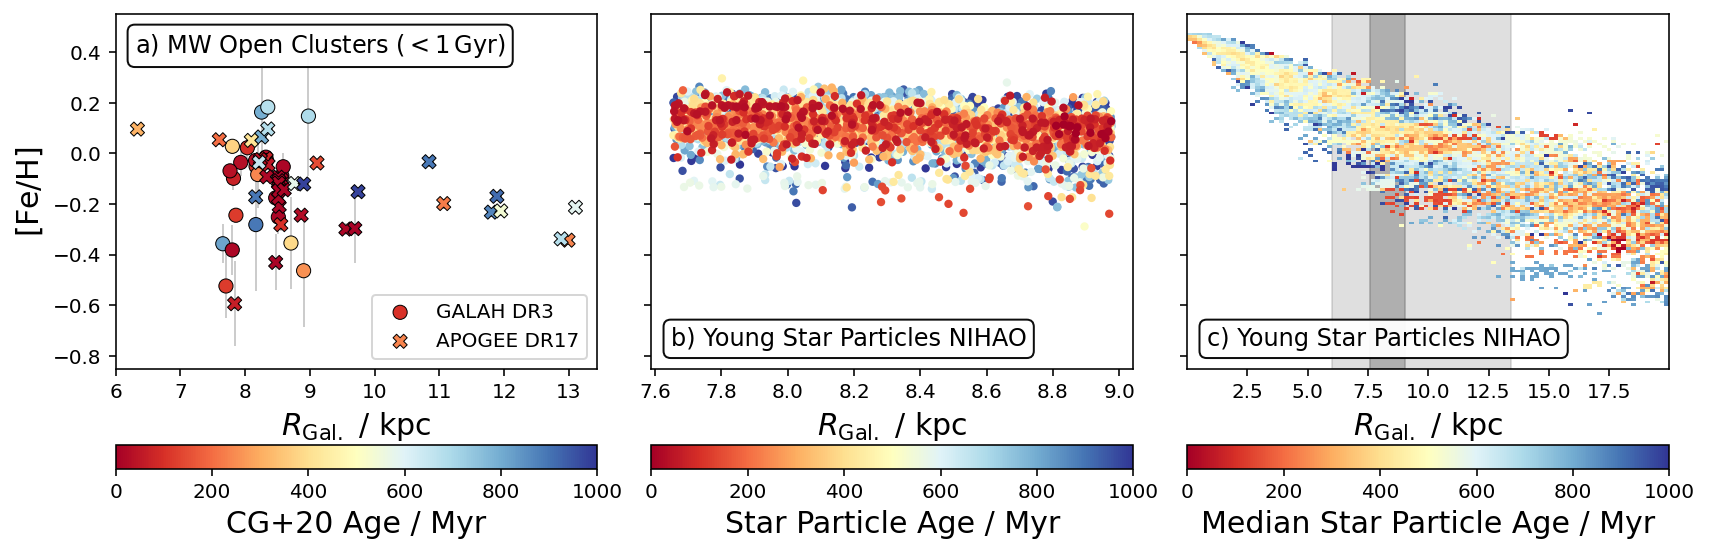

In [25]:
def plot_radius_metallicity_gradient(maximum_age_myr = 1000, z_max_pc = 2000):

    f, gs = plt.subplots(1,3,figsize=(12,4),sharey=True)

    ax = gs[0]
    ax.text(0.04,0.95,panels[0]+r' MW Open Clusters ($<1\,\mathrm{Gyr}$)',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
    ax.set_xlabel(r'$R_\mathrm{Gal.}~/~\mathrm{kpc}$')
    ax.set_ylabel(r'$\mathrm{[Fe/H]}$')

    galah_subset = (
        (oc_galah_dr3_unique['Age_Myr'] < maximum_age_myr) &
        (np.abs(oc_galah_dr3_unique['z_Rzphi_median']) < z_max_pc / 1000.)
    )

    ax.errorbar(
        oc_galah_dr3_unique['R_Rzphi_median'][galah_subset],
        oc_galah_dr3_unique['fe_h_median'][galah_subset],
        yerr = oc_galah_dr3_unique['fe_h_scatter'][galah_subset],
        c = 'k', fmt = '.', lw = 0.2,
        zorder = 1
    )
    
    s = ax.scatter(
        oc_galah_dr3_unique['R_Rzphi_median'][galah_subset],
        oc_galah_dr3_unique['fe_h_median'][galah_subset],
        c = oc_galah_dr3_unique['Age_Myr'][galah_subset],
        s = 50, vmin = 0, vmax = maximum_age_myr, lw=0.5, edgecolor='k',
        zorder = 2, label = 'GALAH DR3', cmap='RdYlBu'
    )
    
    apogee_subset = (
        (oc_apogee_dr17_unique['Age_Myr'] < maximum_age_myr) &
        (np.abs(oc_apogee_dr17_unique['z_Rzphi_median']) < z_max_pc / 1000.)
    )

    ax.errorbar(
        oc_apogee_dr17_unique['R_Rzphi_median'][apogee_subset],
        oc_apogee_dr17_unique['fe_h_median'][apogee_subset],
        yerr = oc_apogee_dr17_unique['fe_h_scatter'][apogee_subset],
        c = 'k', fmt = '.', lw = 0.2,
        zorder = 1
    )
    
    s = ax.scatter(
        oc_apogee_dr17_unique['R_Rzphi_median'][apogee_subset],
        oc_apogee_dr17_unique['fe_h_median'][apogee_subset],
        c = oc_apogee_dr17_unique['Age_Myr'][apogee_subset],
        marker = 'X', s = 50, vmin = 0, vmax = maximum_age_myr, lw=0.5, edgecolor='k',
        zorder = 2, label = 'APOGEE DR17', cmap='RdYlBu'
    )
    ax.legend(fontsize=10,loc='lower right')
    plt.colorbar(s, ax=ax, label='CG+20 Age / Myr', orientation='horizontal')
    
    axx = ax.get_xlim()
    
    ax = gs[1]
    ax.text(0.04,0.05,panels[1]+' Young Star Particles NIHAO',fontsize=12,transform=ax.transAxes,va='bottom',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
    ax.set_xlabel(r'$R_\mathrm{Gal.}~/~\mathrm{kpc}$')
    #ax.set_ylabel(r'$\mathrm{[Fe/H]}$')
    #ax.yaxis.set_tick_params(labelleft=True)

    young_star_particles = (
        (sim_stars['age'] < maximum_age_myr/1000.) &
        (sim_stars['R'] > np.min(oc_galah_dr3_unique['R_Rzphi_median'][galah_subset])) &
        (sim_stars['R'] < np.max(oc_galah_dr3_unique['R_Rzphi_median'][galah_subset])) &
        (np.abs(sim_stars['z']) < np.max(z_max_pc / 1000.))
    )
    
    s = ax.scatter(
        sim_stars['R'][young_star_particles],
        sim_stars['Fe_H'][young_star_particles],
        c = sim_stars['age'][young_star_particles] * 1000.,
        s = 10, vmin = 0, vmax = maximum_age_myr, cmap='RdYlBu',
        zorder = 1
    )
    plt.colorbar(s, ax=ax, label='Star Particle Age / Myr', orientation='horizontal')

    axx2 = ax.get_xlim()

    ax = gs[2]
    ax.text(0.04,0.05,panels[2]+' Young Star Particles NIHAO',fontsize=12,transform=ax.transAxes,va='bottom',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
    ax.set_xlabel(r'$R_\mathrm{Gal.}~/~\mathrm{kpc}$')
    #ax.set_ylabel(r'$\mathrm{[Fe/H]}$')
    #ax.yaxis.set_tick_params(labelleft=True)

    young_star_particles = (
        (sim_stars['age'] < maximum_age_myr/1000.) &
        (sim_stars['R'] < 20.) &
        (sim_stars['z'] < 0.1)
    )

    stats, x_edge, y_edge, _ = binned_statistic_2d(
        sim_stars['R'][young_star_particles], 
        sim_stars['Fe_H'][young_star_particles],
        sim_stars['age'][young_star_particles]*1000, statistic='median',
        bins=100)
    pcm = ax.pcolormesh(x_edge, y_edge, stats.T, shading='auto', cmap='RdYlBu', vmin = 0, vmax = maximum_age_myr,)
    plt.colorbar(pcm, ax=ax, label='Median Star Particle Age / Myr', orientation='horizontal')

    ax.set_ylim(-0.85,0.55,100)
    
    ax.axvspan(
        axx[0],
        axx[1],
        zorder = 0,
        color = 'grey',
        alpha = 0.25
    )
    ax.axvspan(
        axx2[0],
        axx2[1],
        zorder = 0,
        color = 'grey',
        alpha = 0.5
    )
    
    plt.tight_layout()
    
    plt.savefig('figures/radial_metallicity_gradients_mw_vs_nihao.png',dpi=200,bbox_inches='tight')
    
    plt.show()
    plt.close()
    
plot_radius_metallicity_gradient()

# Poggio et al. (2021)

In [26]:
poggio2021_xvalues=np.load('data/Poggio_2021A&A...651A.104P_xvalues.npy')
poggio2021_yvalues=np.load('data/Poggio_2021A&A...651A.104P_yvalues.npy')
poggio2021_overdens_grid=np.load('data/Poggio_2021A&A...651A.104P_overdens_grid_locscale03.npy')

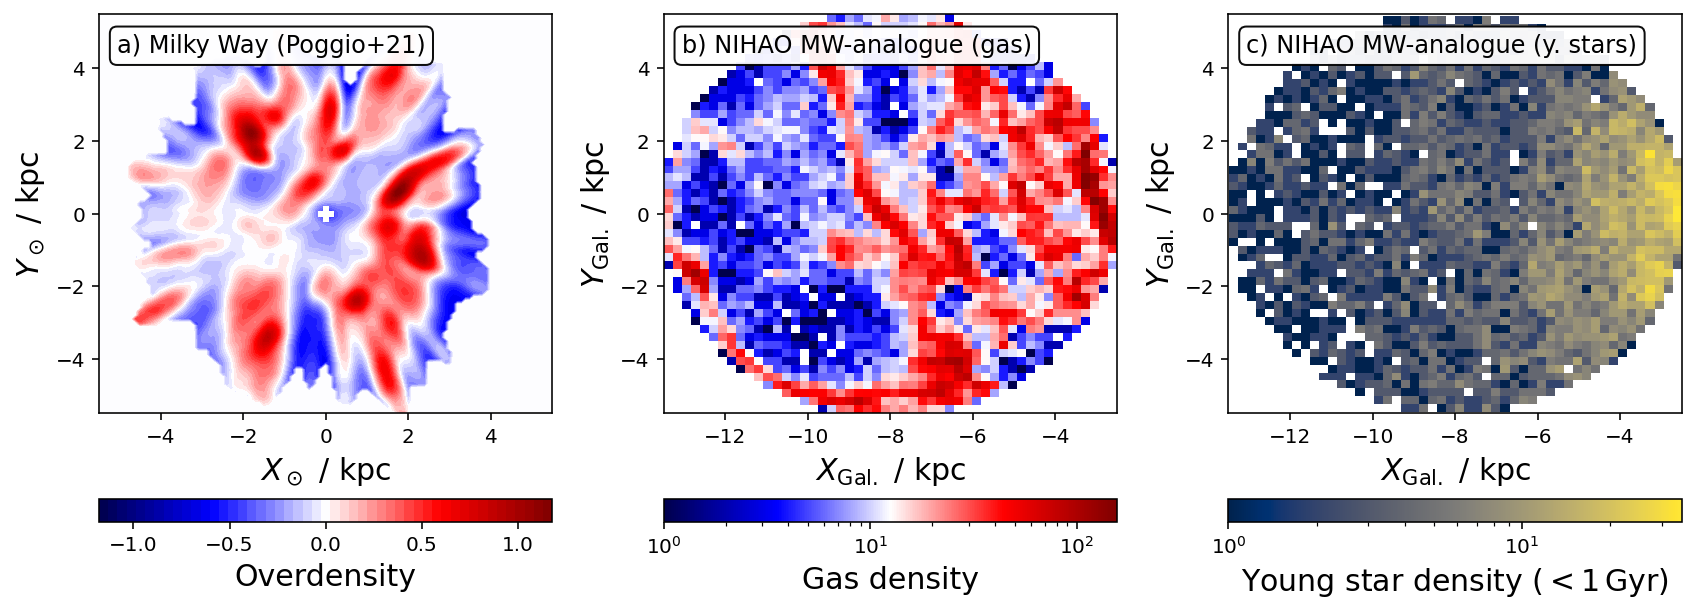

In [27]:
f, gs = plt.subplots(1,3,figsize = (12,4.5))

ax = gs[0]
ax.text(0.04,0.95,panels[0]+' Milky Way (Poggio+21)',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.set_xlabel(r'$X_\odot~/~\mathrm{kpc}$')
ax.set_ylabel(r'$Y_\odot~/~\mathrm{kpc}$')

iniz=-1.18
fin=1.18
N_levels=50
levels=np.linspace(iniz,fin,N_levels)
cset1 = ax.contourf(poggio2021_xvalues, poggio2021_yvalues,poggio2021_overdens_grid.T, levels=levels, cmap='seismic',vmin=-1.18,vmax=1.18)
cbar=plt.colorbar(mappable=cset1,ax=ax,orientation="horizontal",ticks=[-1,-0.5, 0,  0.5, 1])
cbar.set_label('Overdensity')
ax.set_xlim([-5.5,5.5])
ax.set_ylim([-5.5,5.5])
ax.plot([0,0],[0,0],marker='P',c='white',markersize=7) # Sun's position

chosen_position = (-8,0)
radius = 5.5
age_cut = 1

ax = gs[1]
ax.text(0.04,0.95,panels[1]+' NIHAO MW-analogue (gas)',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.set_xlabel(r'$X_\mathrm{Gal.}~/~\mathrm{kpc}$')
ax.set_ylabel(r'$Y_\mathrm{Gal.}~/~\mathrm{kpc}$')

within_radius = (
    (abs(sim_gas['x'] - chosen_position[0]) < radius) &
    (abs(sim_gas['y'] - chosen_position[1]) < radius) &
    (np.sqrt((sim_gas['x']-chosen_position[0])**2 + (sim_gas['y']-chosen_position[1])**2) < radius)
)

h = ax.hist2d(
    sim_gas['x'][within_radius],
    sim_gas['y'][within_radius],
    bins = 50, norm = LogNorm(),
    cmap = 'seismic', cmin = 1
)
plt.colorbar(h[-1], ax=ax, label='Gas density', orientation='horizontal')
ax.set_xlim([-5.5-8,5.5-8])
ax.set_ylim([-5.5,5.5])

ax = gs[2]
ax.text(0.04,0.95,panels[2]+' NIHAO MW-analogue (y. stars)',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.set_xlabel(r'$X_\mathrm{Gal.}~/~\mathrm{kpc}$')
ax.set_ylabel(r'$Y_\mathrm{Gal.}~/~\mathrm{kpc}$')

within_radius = (
    (abs(sim_stars['x'] - chosen_position[0]) < radius) &
    (abs(sim_stars['y'] - chosen_position[1]) < radius) &
    (np.sqrt((sim_stars['x']-chosen_position[0])**2 + (sim_stars['y']-chosen_position[1])**2) < radius) &
    (sim_stars['age'] < age_cut)
)

h = ax.hist2d(
    sim_stars['x'][within_radius],
    sim_stars['y'][within_radius],
    bins = 50, norm = LogNorm(),
    cmap = 'cividis', cmin = 1
)
plt.colorbar(h[-1], ax=ax, label='Young star density ($< '+str(age_cut)+'\,\mathrm{Gyr}$)', orientation='horizontal')
ax.set_xlim([-5.5-8,5.5-8])
ax.set_ylim([-5.5,5.5])

plt.tight_layout()
plt.savefig('figures/overdensities_mw_vs_nihao.png',dpi=300,bbox_inches='tight')